#**CIS545 Project: Open Food Fact Analysis**

```
Renyu Liu, Yuxin Meng, Lingpei Luo
Dec 15th, 2022
```






#**Motivation**

In this project, we take comprehensive data about open food fact to develop various predictive ML models based on the notions of regression, random forests, and feedforward neural nets.

The main objective of the project is to better understand the open food fact using unsupervised and supervised learning. We want to see whether or not we can use regression models to predict nutrition scores and use classification models to predict plan-based and sugary products. In addition, we want to use clustering to segment the whole dataset into several groups and analyze intrinsic patterns.

We also explore questions that interest us about nutrition such as how energy, fat and sugar are related to each other and how they categorize different products.

# **Data loading**


In [ ]:
# Sklearn and Pandas Setup
import json
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from wordcloud import WordCloud

In [ ]:
!pip install swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import swifter

In [ ]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!apt update

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 261 kB in 3s (85.2 kB/s)
Reading package li

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!!kaggle datasets download -d openfoodfacts/world-food-facts

['world-food-facts.zip: Skipping, found more recently modified local copy (use --force to force download)']

In [ ]:
!unzip /content/world-food-facts.zip

Archive:  /content/world-food-facts.zip
replace en.openfoodfacts.org.products.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: en.openfoodfacts.org.products.tsv  y
y
y



In [ ]:
'''food_df = pd.DataFrame()

#read file chunk by chunk to avoid crash due to RAM
reader = pd.read_csv('/content/en.openfoodfacts.org.products.tsv', sep='\t', chunksize=60000)

for df in reader:
    food_df = food_df.append(df, ignore_index=True)'''

"food_df = pd.DataFrame()\n\n#read file chunk by chunk to avoid crash due to RAM\nreader = pd.read_csv('/content/en.openfoodfacts.org.products.tsv', sep='\t', chunksize=60000)\n\nfor df in reader:\n    food_df = food_df.append(df, ignore_index=True)"

In [ ]:
food_df = pd.read_csv('/content/en.openfoodfacts.org.products.tsv', sep='\t')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
food_df.shape

(356027, 163)

# **Data preprocessing**

## Check missing values 

In [ ]:
def missing_value_plot(data, threshold):
    
    plt.figure(figsize=(15,5))
    data_perct=(data.isnull().mean())*100
    data_perct.sort_values(ascending=False).plot.bar(color = 'black', edgecolor = 'black')
    plt.axhline(y = threshold, color='r')
    plt.title('Missing values percentage per feature', fontsize=15, weight='bold' )
    plt.text(len(data.isnull().sum()/len(data))/1.7, threshold+12.5, 'Features with more than %s%s missing values' %(threshold, '%'), fontsize=15,weight='bold', color='red',
         ha='left' ,va='top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, threshold - 5, 'Features with less than %s%s missing values' %(threshold, '%'), fontsize=15,weight='bold', color='blue',
         ha='left' ,va='top')
    plt.xlabel('Features', size=15, weight='bold')
    plt.ylabel('Missing values percentage', weight='bold')
    plt.yticks(weight ='bold')
    
    return plt.show()

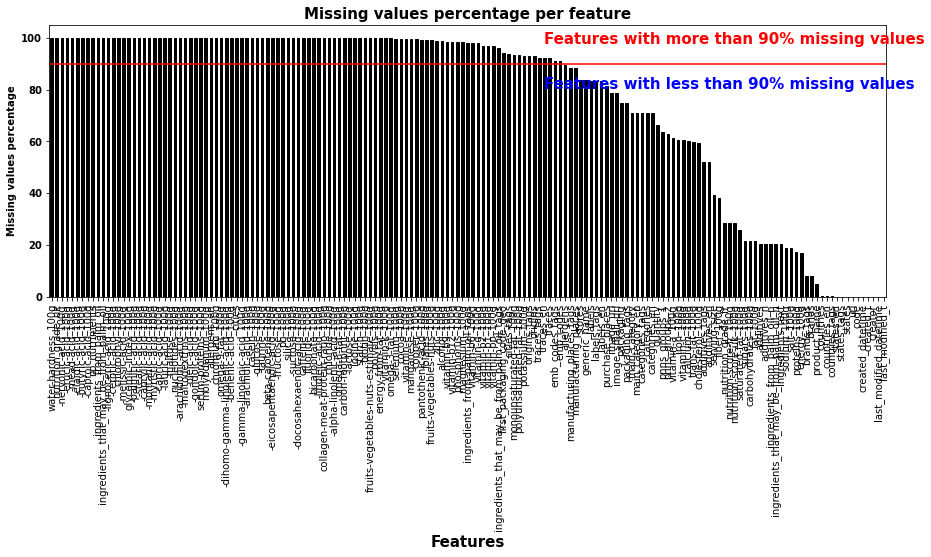

In [ ]:
missing_value_plot(food_df,90)

In [ ]:
food_df_nan = food_df.isnull().sum()
food_df_nan = food_df_nan / food_df.shape[0] * 100

def split_data(threshold):
    cols_of_interest = food_df_nan[food_df_nan <= threshold].index
    data = food_df[cols_of_interest]
    data_1 = data.copy()
    return data_1

food_df_without_nan = split_data(10)

print("Original number of features: " + str(food_df.shape[1]))
print("Number of features with less than 10 % nans: " + str(food_df_without_nan.shape[1]))

Original number of features: 163
Number of features with less than 10 % nans: 16


## Check the rows with non-nan values

We can see that the data have many nan values. All the rows contain at least one nan value. 

In [ ]:
# Cleaning if any values are empty in a row
food_df["isempty"] = np.where(food_df[food_df.columns].isnull().sum(axis=1) >= 1, 1, 0)
# Estimation of cleaning proportion
percentage = (food_df.isempty.value_counts()[1] / food_df.shape[0]) * 100
print("Percentage of incomplete tables: " + str(percentage))
print(food_df.isempty.value_counts())


Percentage of incomplete tables: 100.0
1    356027
Name: isempty, dtype: int64


## Drop Empty rows

In [ ]:
food_df_clean = food_df.dropna(axis = 0, how = 'all')

## Drop empty columns

In [ ]:
# find empty rows and columns in the df
def find_empty_columns(df):
    df_missing_columns = df.isnull().sum(axis=0).reset_index()
    df_missing_columns.columns = ['name', 'count']
    df_missing_columns['ratio'] = (df.shape[0]-df_missing_columns['count']) / df.shape[0]
    return df_missing_columns

In [ ]:
# there are 16 columns that have no value
df_missing_columns = find_empty_columns(food_df_clean)
print(df_missing_columns[df_missing_columns['ratio'] == 0])

                                      name   count  ratio
41                           no_nutriments  356027    0.0
47               ingredients_from_palm_oil  356027    0.0
50   ingredients_that_may_be_from_palm_oil  356027    0.0
52                      nutrition_grade_uk  356027    0.0
67                      -butyric-acid_100g  356027    0.0
68                      -caproic-acid_100g  356027    0.0
77                   -lignoceric-acid_100g  356027    0.0
78                      -cerotic-acid_100g  356027    0.0
80                     -melissic-acid_100g  356027    0.0
94                      -elaidic-acid_100g  356027    0.0
96                         -mead-acid_100g  356027    0.0
97                       -erucic-acid_100g  356027    0.0
98                     -nervonic-acid_100g  356027    0.0
157                        chlorophyl_100g  356027    0.0
161                    glycemic-index_100g  356027    0.0
162                    water-hardness_100g  356027    0.0


In [ ]:
# drop the columns that have no value 
food_df_clean = food_df_clean.dropna(axis = 1, how = 'all')
food_df_clean.shape

(356027, 148)

## Drop row duplicate

In [ ]:
#TO-DO: Drop the duplicate rows
food_df_clean.drop_duplicates(inplace = True)

## Drop outliers

In [ ]:
print(food_df_clean.shape)

(356027, 148)


In [ ]:
quantile=0.01 # here we set the threshold

num_col = food_df_clean.select_dtypes("float").columns.tolist()
del num_col[-1]

qmax=food_df_clean[num_col].quantile(q=1-quantile, axis=0, interpolation='higher') # we get the 99,9% quantile 
print(qmax)



additives_n                                  11.0
ingredients_from_palm_oil_n                   1.0
ingredients_that_may_be_from_palm_oil_n       1.0
energy_100g                                3347.0
energy-from-fat_100g                       3220.0
                                            ...  
fruits-vegetables-nuts-estimate_100g        100.0
collagen-meat-protein-ratio_100g             25.0
cocoa_100g                                  100.0
carbon-footprint_100g                      2509.0
nutrition-score-fr_100g                      27.0
Name: 0.99, Length: 90, dtype: float64


In [ ]:
qmin=food_df_clean[num_col].quantile(q=quantile, axis=0, interpolation='lower') # we get the 0,01% quantile
print(qmin)

additives_n                                 0.0
ingredients_from_palm_oil_n                 0.0
ingredients_that_may_be_from_palm_oil_n     0.0
energy_100g                                 0.0
energy-from-fat_100g                        0.0
                                           ... 
fruits-vegetables-nuts-estimate_100g        3.3
collagen-meat-protein-ratio_100g           12.0
cocoa_100g                                 14.5
carbon-footprint_100g                       0.0
nutrition-score-fr_100g                    -6.0
Name: 0.01, Length: 90, dtype: float64


In [ ]:
for col in num_col:
    valmax=qmax[col]
    valmin=qmin[col]
    
    if (valmax > valmin):
      _clean=food_df_clean[food_df_clean[col]<=valmax] # we keep values under the quantile max
      _clean=food_df_clean[food_df_clean[col]>=valmin] # we keep values over the quantile min
      
print(_clean.shape)

(252389, 148)


We have only **252389 rows** left!

In [ ]:
food_df_clean = _clean
print(food_df_clean.shape)

(252389, 148)


## Tidying Up

Upon inspection, we can see that the `countries` and `countries_tags` columns are not going to be useful since they have more error and `countries_en` already contains the information. 

We will keep everything else for now and do more data cleaning before we do specific modelling.

In [ ]:
# Drop the "countries" and "countries_tags" columns, but keep everything else for now
# we will do more data cleaning before we do specific modelling
food_df_clean = food_df_clean.drop(columns = ['countries','countries_tags'])

#**EDA**

##Overview

In [ ]:
food_df_clean.shape


(252389, 146)

There are 356027 rows, 146 columns in total. Take an extra look at to columns:

In [ ]:
food_df_clean.dtypes

code                        object
url                         object
creator                     object
created_t                   object
created_datetime            object
                            ...   
cocoa_100g                 float64
carbon-footprint_100g      float64
nutrition-score-fr_100g    float64
nutrition-score-uk_100g    float64
isempty                      int64
Length: 146, dtype: object

In [ ]:
food_df_clean.head(5)

code                                                url          creator  \
1    4530  http://world-en.openfoodfacts.org/product/0000...  usda-ndb-import   
2    4559  http://world-en.openfoodfacts.org/product/0000...  usda-ndb-import   
3   16087  http://world-en.openfoodfacts.org/product/0000...  usda-ndb-import   
7   16124  http://world-en.openfoodfacts.org/product/0000...  usda-ndb-import   
12  16872  http://world-en.openfoodfacts.org/product/0000...  usda-ndb-import   

     created_t      created_datetime last_modified_t last_modified_datetime  \
1   1489069957  2017-03-09T14:32:37Z      1489069957   2017-03-09T14:32:37Z   
2   1489069957  2017-03-09T14:32:37Z      1489069957   2017-03-09T14:32:37Z   
3   1489055731  2017-03-09T10:35:31Z      1489055731   2017-03-09T10:35:31Z   
7   1489055711  2017-03-09T10:35:11Z      1489055712   2017-03-09T10:35:12Z   
12  1489055650  2017-03-09T10:34:10Z      1489055651   2017-03-09T10:34:11Z   

                      product_name generic_name quantity  ... taurine_100g  \
1   Banana Chips Sweetened (Whole)          NaN      NaN  ...          NaN   
2                          Peanuts          NaN      NaN  ...          NaN   
3           Organic Salted Nut Mix          NaN      NaN  ...          NaN   
7                   Organic Muesli          NaN      NaN  ...          NaN   
12                   Zen Party Mix          NaN      NaN  ...          NaN   

   ph_100g fruits-vegetables-nuts_100g fruits-vegetables-nuts-estimate_100g  \
1      NaN                         NaN                                  NaN   
2      NaN                         NaN                                  NaN   
3      NaN                         NaN                                  NaN   
7      NaN                         NaN                                  NaN   
12     NaN                         NaN                                  NaN   

   collagen-meat-protein-ratio_100g cocoa_100g carbon-footprint_100g  \
1                               NaN        NaN                   NaN   
2                               NaN        NaN                   NaN   
3                               NaN        NaN                   NaN   
7                               NaN        NaN                   NaN   
12                              NaN        NaN                   NaN   

   nutrition-score-fr_100g nutrition-score-uk_100g isempty  
1                     14.0                    14.0       1  
2                      0.0                     0.0       1  
3                     12.0                    12.0       1  
7                      7.0                     7.0       1  
12                    12.0                    12.0       1  

[5 rows x 146 columns]

In [ ]:
food_df_clean.describe()

additives_n  ingredients_from_palm_oil_n  \
count  227838.000000                227838.000000   
mean        1.931153                     0.026440   
std         2.529992                     0.162316   
min         0.000000                     0.000000   
25%         0.000000                     0.000000   
50%         1.000000                     0.000000   
75%         3.000000                     0.000000   
max        30.000000                     2.000000   

       ingredients_that_may_be_from_palm_oil_n    energy_100g  \
count                            227838.000000  252192.000000   
mean                                  0.063317    1178.111785   
std                                   0.290026     895.195398   
min                                   0.000000       0.000000   
25%                                   0.000000     456.000000   
50%                                   0.000000    1180.000000   
75%                                   0.000000    1715.000000   
max                                   6.000000  231199.000000   

       energy-from-fat_100g       fat_100g  saturated-fat_100g  \
count            780.000000  236450.000000       252192.000000   
mean             547.766962      13.499330            5.008687   
std              626.477915      16.371936            7.680739   
min                0.000000       0.000000            0.000000   
25%               61.800000       0.900000            0.000000   
50%              300.000000       7.300000            1.790000   
75%              888.500000      21.430000            7.140000   
max             3590.000000     200.000000          550.000000   

       -caprylic-acid_100g  -capric-acid_100g  -lauric-acid_100g  ...  \
count                  0.0                0.0           2.000000  ...   
mean                   NaN                NaN          24.522365  ...   
std                    NaN                NaN          34.616603  ...   
min                    NaN                NaN           0.044730  ...   
25%                    NaN                NaN          12.283547  ...   
50%                    NaN                NaN          24.522365  ...   
75%                    NaN                NaN          36.761183  ...   
max                    NaN                NaN          49.000000  ...   

       taurine_100g    ph_100g  fruits-vegetables-nuts_100g  \
count     31.000000  10.000000                  2989.000000   
mean      13.038639   7.090000                    31.733580   
std       71.817185   0.634998                    32.593114   
min        0.000720   6.000000                     0.000000   
25%        0.035000   6.625000                     0.000000   
50%        0.039000   7.200000                    22.000000   
75%        0.400000   7.425000                    51.200000   
max      400.000000   8.200000                   100.000000   

       fruits-vegetables-nuts-estimate_100g  collagen-meat-protein-ratio_100g  \
count                            353.000000                        118.000000   
mean                              59.641331                         15.686441   
std                               29.772847                          4.098570   
min                                0.000000                          8.000000   
25%                               45.000000                         12.000000   
50%                               56.000000                         15.000000   
75%                               93.000000                         15.000000   
max                              100.000000                         25.000000   

        cocoa_100g  carbon-footprint_100g  nutrition-score-fr_100g  \
count  1246.000000             235.000000            252389.000000   
mean     51.675361             347.808105                 9.335339   
std      19.118812             442.881901                 8.877648   
min       6.000000               0.000000                -6.000000   
25%      32.625000              79.350000   



---


Here, for a better understanding of the relationships between the features of the dataset and a better analysis of it, we opted to study the core systematics and meanings of the contents columns of the dataframe.


---
**Hierarchy of contents columns**


---

* fat
 * saturated-fat
   * -butyric-acid
   * -caproic-acid
   * -caprylic-acid
   * -capric-acid
   * -lauric-acid
   * -myristic-acid
   * -palmitic-acid
   * -stearic-acid
   * -arachidic-acid
   * -behenic-acid
   * -lignoceric-acid
   * -cerotic-acid
   * -montanic-acid
   * -melissic-acid
 * monounsaturated-fat
 * polyunsaturated-fat
 * omega-3-fat
   * -alpha-linolenic-acid
   * -eicosapentaenoic-acid
   * -docosahexaenoic-acid
 * omega-6-fat
   * -linoleic-acid
   * -arachidonic-acid
   * -gamma-linolenic-acid
   * -dihomo-gamma-linolenic-acid
 * omega-9-fat
   * -oleic-acid
   * -elaidic-acid
   * -gondoic-acid
   * -mead-acid
   * -erucic-acid
   * -nervonic-acid
 * trans-fat

* cholesterol

* carbohydrates
 * sugars
   * -sucrose
   * -glucose
   * -fructose
   * -lactose
   * -maltose
   * -maltodextrins
 * starch
 * polyols
 * fiber

* proteins
 * casein
 * serum-proteins

* nucleotides

* salt

* sodium

* alcohol

* (vitamins)
 * vitamin-a
 * beta-carotene (provitamin, precursor of vitamin a)
 * vitamin-d
 * vitamin-e
 * vitamin-k
 * vitamin-c
 * vitamin-b1
 * vitamin-b2
 * vitamin-pp
 * vitamin-b6
 * vitamin-b9
 * folates (natural form of vitamin-b9)
 * vitamin-b12
 * biotin (vitamin-b7)
 * pantothenic-acid (vitamin-b5)

* silica

* bicarbonate

* potassium

* chloride

* calcium

* phosphorus

* iron

* magnesium

* zinc

* copper

* manganese

* fluoride

* selenium

* chromium

* molybdenum

* iodine

* caffeine

* taurine

* cocoa

* chlorophyl



##Correlation Matrix

Check how nutrition-score is correlated with other columns:

In [ ]:
corr_matrix = food_df_clean.corr()

corr_matrix

additives_n  \
additives_n                                 1.000000   
ingredients_from_palm_oil_n                 0.133404   
ingredients_that_may_be_from_palm_oil_n     0.306709   
energy_100g                                 0.006808   
energy-from-fat_100g                       -0.106767   
...                                              ...   
cocoa_100g                                 -0.206839   
carbon-footprint_100g                       0.062201   
nutrition-score-fr_100g                     0.157055   
nutrition-score-uk_100g                     0.154695   
isempty                                          NaN   

                                         ingredients_from_palm_oil_n  \
additives_n                                                 0.133404   
ingredients_from_palm_oil_n                                 1.000000   
ingredients_that_may_be_from_palm_oil_n                     0.184938   
energy_100g                                                 0.098350   
energy-from-fat_100g                                        0.045806   
...                                                              ...   
cocoa_100g                                                 -0.229648   
carbon-footprint_100g                                       0.050498   
nutrition-score-fr_100g                                     0.129977   
nutrition-score-uk_100g                                     0.133467   
isempty                                                          NaN   

                                         ingredients_that_may_be_from_palm_oil_n  \
additives_n                                                             0.306709   
ingredients_from_palm_oil_n                                             0.184938   
ingredients_that_may_be_from_palm_oil_n                                 1.000000   
energy_100g                                                             0.024980   
energy-from-fat_100g                                                    0.090917   
...                                                                          ...   
cocoa_100g                                                             -0.099119   
carbon-footprint_100g                                                  -0.051958   
nutrition-score-fr_100g                                                 0.058805   
nutrition-score-uk_100g                                                 0.061155   
isempty                                                                      NaN   

                                         energy_100g  energy-from-fat_100g  \
additives_n                                 0.006808             -0.106767   
ingredients_from_palm_oil_n                 0.098350              0.045806   
ingredients_that_may_be_from_palm_oil_n     0.024980              0.090917   
energy_100g                                 1.000000              0.746671   
energy-from-fat_100g                        0.746671              1.000000   
...                                              ...                   ...   
cocoa_100g                                  0.174377              1.000000   
carbon-footprint_100g                       0.192566                   NaN   
nutrition-score-fr_100g                     0.530662              0.539773   
nutrition-score-uk_100g                     0.564329              0.568283   
isempty                                          NaN                   NaN   

                                         fat_100g  saturated-fat_100g  \
additives_n                             -0.090952           -0.038232   
ingredients_from_palm_oil_n              0.068093            0.098675   
ingredients_that_may_be_from_palm_oil_n  0.019161            0.037322   
energy_100g                              0.768841            0.544807   
energy-from-fat_100g                     0.977629            0.691771   
...                                           ...                 ...   
cocoa_100g                               0.532

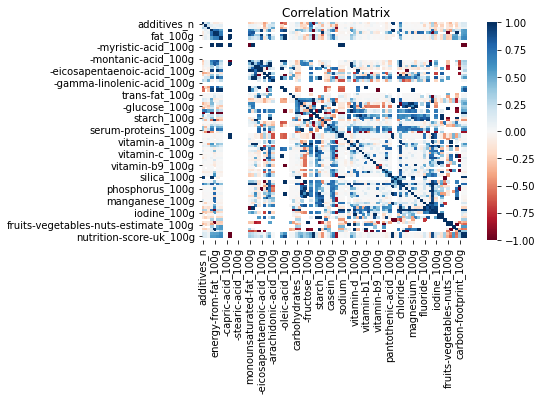

In [ ]:
#a simple visualization, which is ugly though
sns.heatmap(corr_matrix, cmap='RdBu', vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")
plt.show() 

A better view:

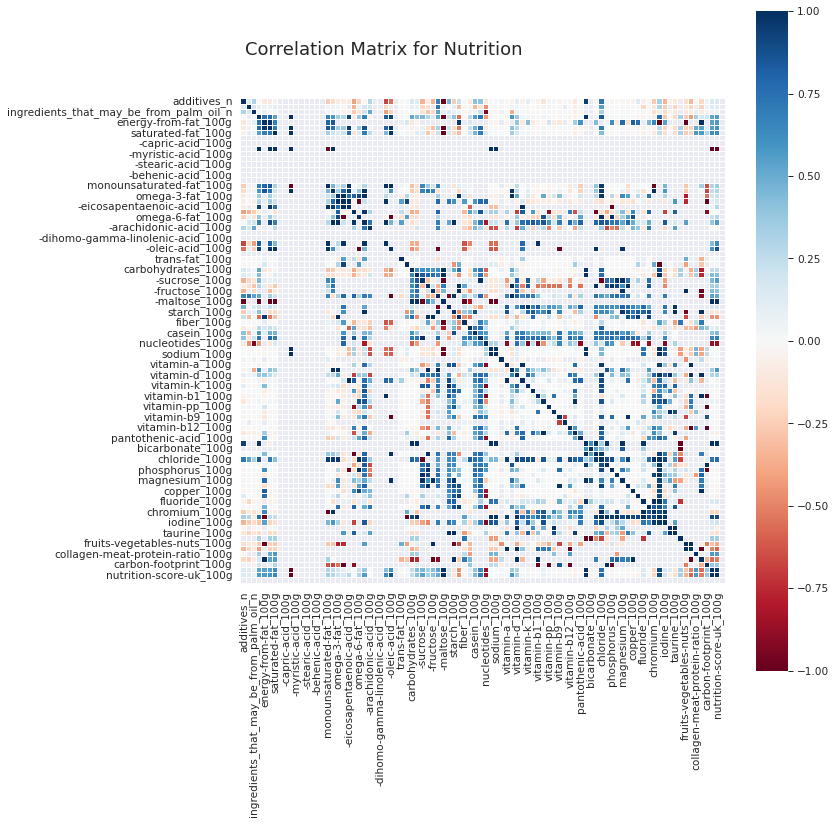

In [ ]:
# Heatmap for the features
sns.set(context="paper", font_scale = 1.2)
# size of the plot
f, ax = plt.subplots(figsize=(12, 12))
# set the plot heading
f.text(0.45, 0.93, "Correlation Matrix for Nutrition", ha='center', fontsize = 18)
# plot matrix as a heatmap
sns.heatmap(corr_matrix, square=True, linewidths=0.01, cmap="RdBu")
plt.tight_layout()

## Relations between selected features and boxplot overview

In this section, we would want to see a boxplot overview for selected features, so as to better understand them before we move onto modelling. These features are:  'saturated-fat_100g', 'fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'energy_100g'. These seven factors are main branches in our structure, food_df_clean, and are also widely considered as nutrition indicators.

In [ ]:
feature_food_df = food_df_clean[['saturated-fat_100g','fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g','energy_100g']]

In [ ]:
#fill all the Nan value with the mean of this feature
feature_food_df['saturated-fat_100g'].fillna(feature_food_df['saturated-fat_100g'].mean(), inplace = True)
feature_food_df['fat_100g'].fillna(feature_food_df['fat_100g'].mean(), inplace = True)
feature_food_df['carbohydrates_100g'].fillna(feature_food_df['carbohydrates_100g'].mean(), inplace = True)
feature_food_df['sugars_100g'].fillna(feature_food_df['sugars_100g'].mean(), inplace = True)
feature_food_df['proteins_100g'].fillna(feature_food_df['proteins_100g'].mean(), inplace = True)
feature_food_df['salt_100g'].fillna(feature_food_df['salt_100g'].mean(), inplace = True)
feature_food_df['energy_100g'].fillna(feature_food_df['energy_100g'].mean(), inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
feature_food_df

saturated-fat_100g  fat_100g  carbohydrates_100g  sugars_100g  \
1                    28.57  28.57000           64.290000        14.29   
2                     0.00  17.86000           60.710000        17.86   
3                     5.36  57.14000           17.860000         3.57   
7                     4.69  18.75000           57.810000        15.62   
12                    5.00  36.67000           36.670000         3.33   
...                    ...       ...                 ...          ...   
355982               99.00  13.49933           32.536523         3.00   
355985                0.00   0.00000           87.060000         2.35   
356005                0.60   2.80000           74.800000         2.60   
356010                3.73  13.49933           32.536523         3.89   
356022                0.00   0.00000            0.000000         0.00   

        proteins_100g  salt_100g  energy_100g  
1                3.57    0.00000       2243.0  
2               17.86    0.63500       1941.0  
3               17.86    1.22428       2540.0  
7               14.06    0.13970       1833.0  
12              16.67    1.60782       2230.0  
...               ...        ...          ...  
355982           7.00   78.00000        837.0  
355985           1.18    0.03048       1477.0  
356005          13.00    0.68000       1643.0  
356010          21.22    0.10000       2406.0  
356022           0.00    0.00000          0.0  

[252389 rows x 7 columns]

First, let us observe the performance of outliers in our data by assigning red circles for all the outliers.

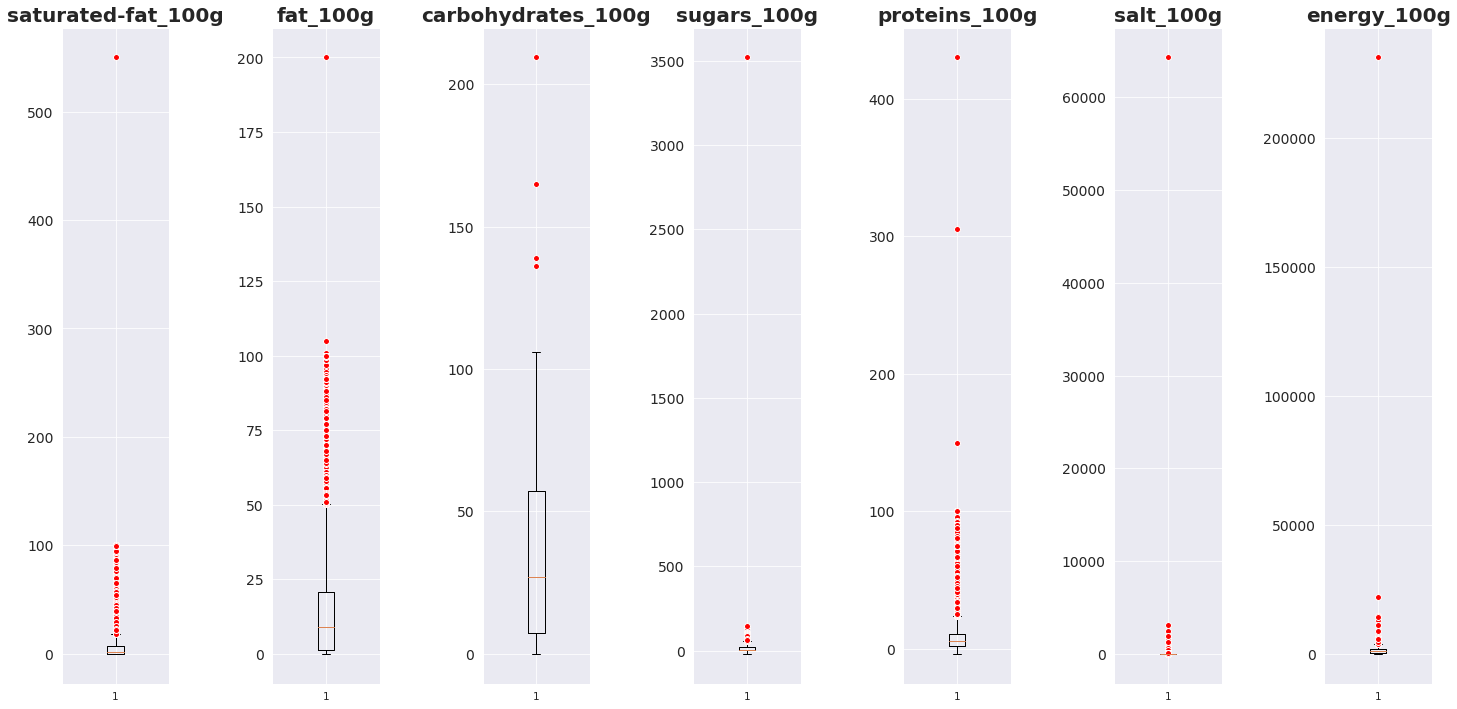

In [ ]:
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(1, len(feature_food_df.columns), figsize=(20,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(feature_food_df.iloc[:,i], flierprops=red_circle)
    feature_food_df.iloc[:,i]
    ax.set_title(feature_food_df.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    
    #Checking if column names are equal to columns we expect to be logarithmic
    if feature_food_df.columns[i] == 'RDEP' or feature_food_df.columns[i] == 'RMED':
        ax.semilogy()
    
plt.tight_layout()

Despite we dropped outliers, we still find most of the features in our data is highly subject to far-away outliers. Next, let us plot without outliers to see their performance.

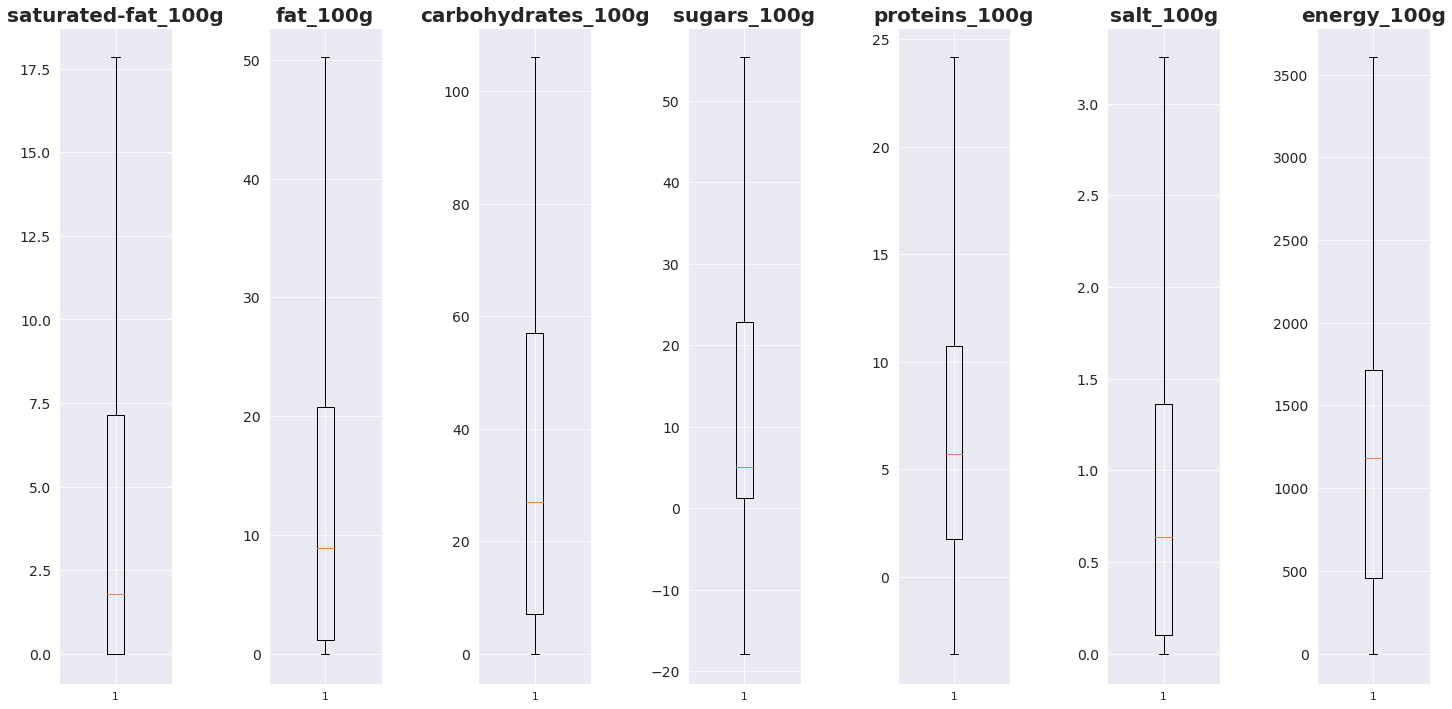

In [ ]:

fig, axs = plt.subplots(1, len(feature_food_df.columns), figsize=(20,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(feature_food_df.iloc[:,i], showfliers=False)
    feature_food_df.iloc[:,i]
    ax.set_title(feature_food_df.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    
    #Checking if column names are equal to columns we expect to be logarithmic
    if feature_food_df.columns[i] == 'RDEP' or feature_food_df.columns[i] == 'RMED':
        ax.semilogy()
    
plt.tight_layout()

After removing the outliers, we notice that each features is clearly mapped onto various scale. So that scaling may be recommend in the later process.

Next, we take a closer look at the correlation between these seven factors.

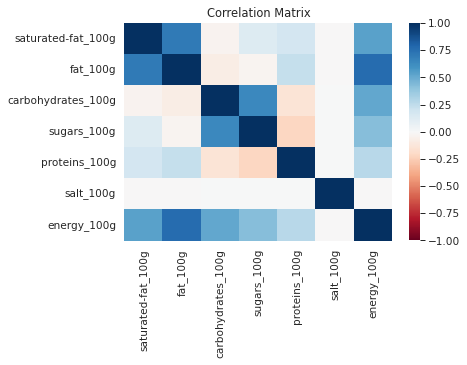

In [ ]:
corr_seven_matrix = food_df_clean[['saturated-fat_100g','fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g','energy_100g']].corr()
#because we have fill Nan value feature_food_df with mean, we use data from food_df_clean
sns.heatmap(corr_seven_matrix, cmap='RdBu', vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")
plt.show() 

From the heatmap, we find high correlation between (fat_100g, saturated-fat_100g), (carbohydrates_100g, sugars_100g). Let us plot some regplots for every pair of them.

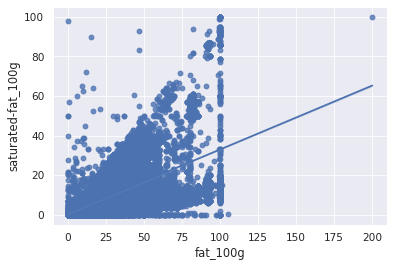

In [ ]:
sns.regplot(x="fat_100g", y="saturated-fat_100g", data=food_df_clean) 

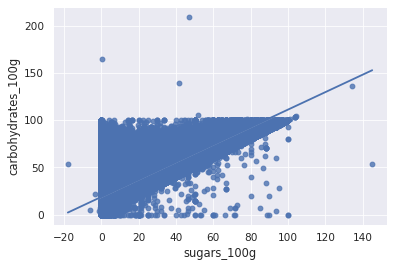

In [ ]:
sns.regplot(x="sugars_100g", y="carbohydrates_100g", data=food_df_clean) 

We do observe the existence of a linear relationship, but maybe not so strong. To have more data for our models later, we shall leave them to data preprocessing (such as PCA) later before running our models.

## Relations among Proteins, Carbohydrates, and Fat

The characteristics of a food can be reflected by its composition, especially by its contents of protein, carbohydrate and fat. For example, meat contains more protein than other foods but less carbohydrate and fat. Thus, the relations among these key compositions are worth deep inverstigation and we intended to investigate how proteins relate to other components as well, and how their relationships are interconnected. 

To analyze the interrelations between pairs, we picked pairplot as it summarizes large amounts of data and clearly visualizes pair relations in a single figure. We then selected 1000 random instances for this part of analysis:


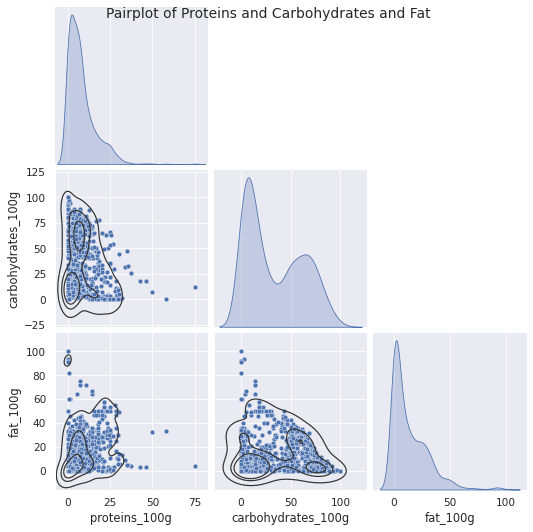

In [ ]:
plot = sns.pairplot(food_df_clean.sample(1000), diag_kind='kde', kind='scatter', palette='hls', 
             vars=['proteins_100g', 'carbohydrates_100g', 'fat_100g'], corner=True)
plot.map_lower(sns.kdeplot, levels=4, color=".2")
plot.fig.suptitle('Pairplot of Proteins and Carbohydrates and Fat');



---
**Basic Distribution**


To begin with, it is not difficult to see that the products in the dataset generally have a protein content ranging from 0g/100g to 25g/100g, which is a relatively small range, and a fat content less than 40g/100g.



---
**Correlations**


1. When protein content increases, there is a downward trend in the distribution of carbohydrates based on protein content. 

2. There is a fairly even distribution of fat based on the level of protein. It is worth noting that there are some outliers, though, in that their fat content is extremely high while their protein content is almost zero. Our speculation is that they might be one of some special products which accounts for a small partition of all products. 

In [ ]:
food_df_clean[(food_df_clean['fat_100g']>=75) & (food_df_clean['proteins_100g']<=5)]['product_name']

552       Ventura, Soybean - Peanut Frying Oil Blend
682                                    Sunflower oil
936                                      Beurre doux
1963                                      Mayonnaise
1986                            Mayo Real Mayonnaise
                             ...                    
354632           Whole Egg Real Mayonaise Squeezable
354852                                   Melrose MCT
355425                             Changs Sesame Oil
355785                          Huile de coco vierge
355875          Healtier palm oil (L'huile de palme)
Name: product_name, Length: 2577, dtype: object

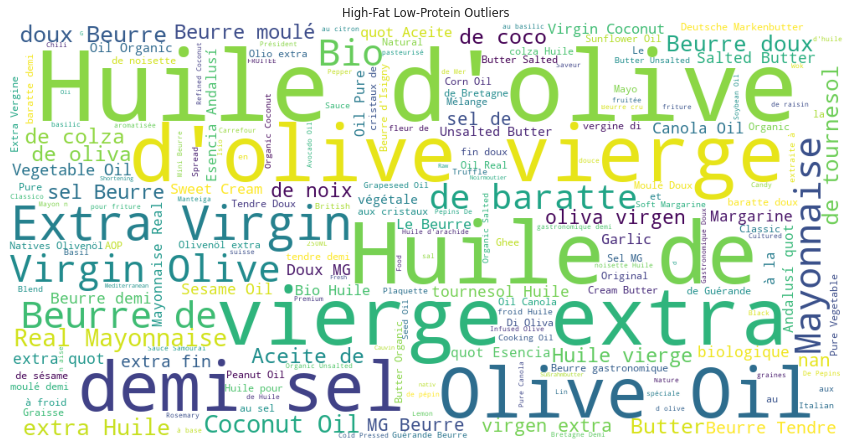

In [ ]:
#get a flattened list of product names
product_name_list = food_df_clean[(food_df_clean['fat_100g']>=75) & (food_df_clean['proteins_100g']<=5)]['product_name'].tolist()
product_names = [str(name) for name in product_name_list]
#create a wordcloud
wordcloud = WordCloud(width = 1000, height = 500, background_color ='white').generate(' '.join(product_names))
#plot
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("High-Fat Low-Protein Outliers")
plt.show()

A quick glance at this group of products will reveal that Oil makes up the majority of the group of products, along with Mayonnaise, Butter, various varieties of Spread, and a variety of other products. 



Similar "outliers" are also found in the pairplot of Fat and Carbohydrates. We wonder if this is the same group of products that were found as "outliers" in the pairplot of fats and proteins that we analyzed earlier. 

In [ ]:
food_df_clean[(food_df_clean['fat_100g']>=75) & (food_df_clean['carbohydrates_100g']<=5)]['product_name']

552       Ventura, Soybean - Peanut Frying Oil Blend
682                                    Sunflower oil
936                                      Beurre doux
1986                            Mayo Real Mayonnaise
1987                                 Real Mayonnaise
                             ...                    
354632           Whole Egg Real Mayonaise Squeezable
354852                                   Melrose MCT
355425                             Changs Sesame Oil
355785                          Huile de coco vierge
355875          Healtier palm oil (L'huile de palme)
Name: product_name, Length: 2511, dtype: object

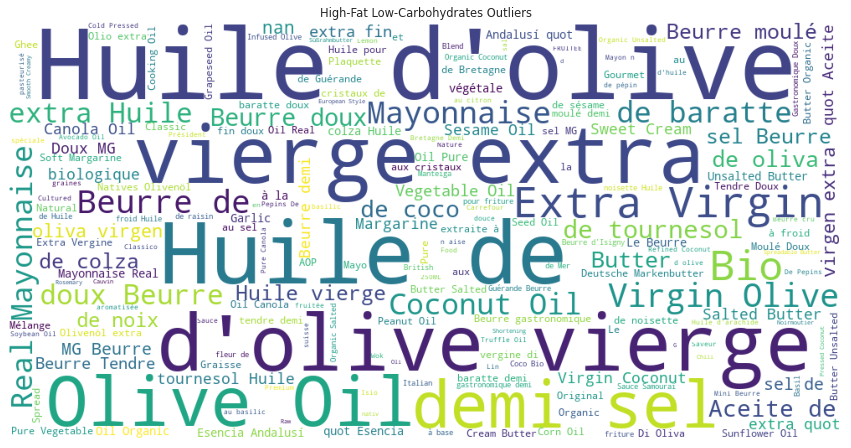

In [ ]:
#get a flattened list of product names
product_name_list = food_df_clean[(food_df_clean['fat_100g']>=75) & (food_df_clean['carbohydrates_100g']<=5)]['product_name'].tolist()
product_names = [str(name) for name in product_name_list]
#create a wordcloud
wordcloud = WordCloud(width = 1000, height = 500, background_color ='white').generate(' '.join(product_names))
#plot
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("High-Fat Low-Carbohydrates Outliers")
plt.show()

It is not suprising to see Oil again being the majority, accompanied by Mayonnaise, Butter, different types, and some other types of food products. 

3. The distribution of fat does not show a steep downward trend as the carbohydrate content rises. There is an interesting gap in the distribution of fat contents within the section where the carbohydrate contents range between 20-30%. It appears that few food products with 20-30% carbohydrates contain 20-40% fat, and this scarcity intrigued us. 

In [ ]:
food_df_clean[(food_df_clean['carbohydrates_100g']>=20) & (food_df_clean['carbohydrates_100g']<=30) & (food_df_clean['fat_100g']<40) & (food_df_clean['fat_100g']>20)]['product_name']

866                           Double Chocolate Mini Eclairs
869                                Belgian Mini Cream Puffs
1585                              New York Style Cheesecake
1603       The Father's Table, Divine New York Style Cheese
2048                                        Sandwich Spread
                                ...                        
350892                                           White Chou
351788                                                  NaN
351792    Blue Elephant Pate De Basilic Thai Pour Saute 70G
352511              Sambal Kecap Sweet Soy Chili Sauce, Hot
355536                                     Bhuja Mix Masala
Name: product_name, Length: 1220, dtype: object

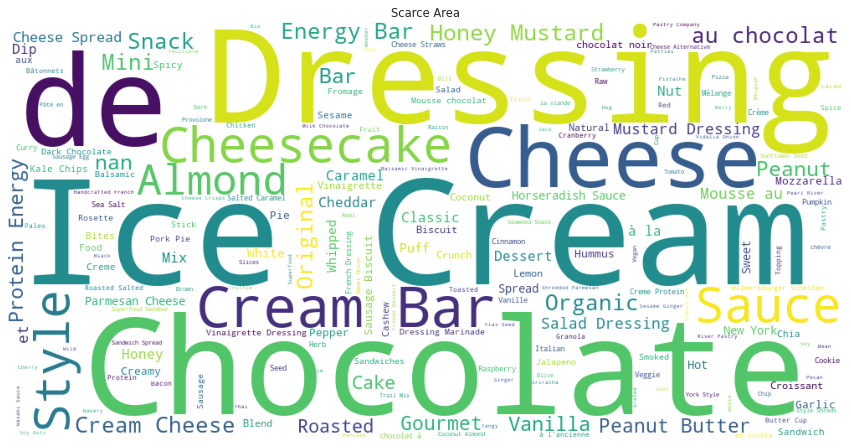

In [ ]:
#get a flattened list of product names
product_name_list = food_df_clean[(food_df_clean['carbohydrates_100g']>=20) & (food_df_clean['carbohydrates_100g']<=30) & (food_df_clean['fat_100g']<40) & (food_df_clean['fat_100g']>20)]['product_name'].tolist()
product_names = [str(name) for name in product_name_list]
#create a wordcloud
wordcloud = WordCloud(width = 1000, height = 500, background_color ='white').generate(' '.join(product_names))
#plot
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Scarce Area")
plt.show()

Unfortunately, we failed to find significant commonalities shared by these products which could explain their scarcity: they certainly share some features, such as the fact that they seem all to have high calories, but it is not clear that these characteristics have a meaningful correlation with the scarcity of products with that particular range of fat and carbohydrate contents. 

As a result, we decided not to move further on this path during this project. It could be meaningful to further explore the possible reasons lying behind this odd phenomenon though.

## Check nutrition-score

Check the instance which has null value for nutrition-score.

In [ ]:
food_df_clean[food_df_clean['nutrition-score-uk_100g'].isna() == True]
#101171 columns is Nan

Empty DataFrame
Columns: [code, url, creator, created_t, created_datetime, last_modified_t, last_modified_datetime, product_name, generic_name, quantity, packaging, packaging_tags, brands, brands_tags, categories, categories_tags, categories_en, origins, origins_tags, manufacturing_places, manufacturing_places_tags, labels, labels_tags, labels_en, emb_codes, emb_codes_tags, first_packaging_code_geo, cities, cities_tags, purchase_places, stores, countries_en, ingredients_text, allergens, allergens_en, traces, traces_tags, traces_en, serving_size, additives_n, additives, additives_tags, additives_en, ingredients_from_palm_oil_n, ingredients_from_palm_oil_tags, ingredients_that_may_be_from_palm_oil_n, ingredients_that_may_be_from_palm_oil_tags, nutrition_grade_fr, pnns_groups_1, pnns_groups_2, states, states_tags, states_en, main_category, main_category_en, image_url, image_small_url, energy_100g, energy-from-fat_100g, fat_100g, saturated-fat_100g, -caprylic-acid_100g, -capric-acid_100g, -lauric-acid_100g, -myristic-acid_100g, -palmitic-acid_100g, -stearic-acid_100g, -arachidic-acid_100g, -behenic-acid_100g, -montanic-acid_100g, monounsaturated-fat_100g, polyunsaturated-fat_100g, omega-3-fat_100g, -alpha-linolenic-acid_100g, -eicosapentaenoic-acid_100g, -docosahexaenoic-acid_100g, omega-6-fat_100g, -linoleic-acid_100g, -arachidonic-acid_100g, -gamma-linolenic-acid_100g, -dihomo-gamma-linolenic-acid_100g, omega-9-fat_100g, -oleic-acid_100g, -gondoic-acid_100g, trans-fat_100g, cholesterol_100g, carbohydrates_100g, sugars_100g, -sucrose_100g, -glucose_100g, -fructose_100g, -lactose_100g, -maltose_100g, -maltodextrins_100g, starch_100g, polyols_100g, fiber_100g, proteins_100g, casein_100g, serum-proteins_100g, ...]
Index: []

[0 rows x 146 columns]

In [ ]:
#selecting the values which is highly correlated to nutrition-score-uk_100g.
# defined as < -0.8 or > 0.8

correlated_df = corr_matrix[corr_matrix['nutrition-score-uk_100g'].apply(lambda x: x > 0.8 or x < -0.8)]
correlated_df


additives_n  ingredients_from_palm_oil_n  \
-lauric-acid_100g                NaN                          NaN   
-oleic-acid_100g           -0.552410                          NaN   
-maltose_100g              -1.000000                          NaN   
nucleotides_100g           -0.094108                    -0.458190   
silica_100g                 0.950005                          NaN   
molybdenum_100g             0.328600                     0.300249   
nutrition-score-fr_100g     0.157055                     0.129977   
nutrition-score-uk_100g     0.154695                     0.133467   

                         ingredients_that_may_be_from_palm_oil_n  energy_100g  \
-lauric-acid_100g                                            NaN     1.000000   
-oleic-acid_100g                                       -0.248401     0.929592   
-maltose_100g                                                NaN    -0.996348   
nucleotides_100g                                       -0.928128    -0.414429   
silica_100g                                                  NaN     0.988062   
molybdenum_100g                                        -0.100434     0.753393   
nutrition-score-fr_100g                                 0.058805     0.530662   
nutrition-score-uk_100g                                 0.061155     0.564329   

                         energy-from-fat_100g  fat_100g  saturated-fat_100g  \
-lauric-acid_100g                         NaN  1.000000            1.000000   
-oleic-acid_100g                          NaN  0.978965            0.983598   
-maltose_100g                             NaN -0.997024           -0.996317   
nucleotides_100g                          NaN -0.114577            0.150289   
silica_100g                               NaN -0.062408                 NaN   
molybdenum_100g                     -1.000000  0.262916            0.247615   
nutrition-score-fr_100g              0.539773  0.553139            0.617736   
nutrition-score-uk_100g              0.568283  0.594273            0.642024   

                         -caprylic-acid_100g  -capric-acid_100g  \
-lauric-acid_100g                        NaN                NaN   
-oleic-acid_100g                         NaN                NaN   
-maltose_100g                            NaN                NaN   
nucleotides_100g                         NaN                NaN   
silica_100g                              NaN                NaN   
molybdenum_100g                          NaN                NaN   
nutrition-score-fr_100g                  NaN                NaN   
nutrition-score-uk_100g                  NaN                NaN   

                         -lauric-acid_100g  ...  taurine_100g   ph_100g  \
-lauric-acid_100g                      1.0  ...           NaN       NaN   
-oleic-acid_100g                       NaN  ...           NaN       NaN   
-maltose_100g                          NaN  ...           NaN       NaN   
nucleotides_100g                       NaN  ...      0.316064       NaN   
silica_100g                            NaN  ...           NaN -1.000000   
molybdenum_100g                        NaN  ...           NaN       NaN   
nutrition-score-fr_100g               -1.0  ...     -0.144046  0.337532   
nutrition-score-uk_100g               -1.0  ...     -0.178653  0.337532   

                         fruits-vegetables-nuts_100g  \
-lauric-acid_100g                                NaN   
-oleic-acid_100g                                 NaN   
-maltose_100g                                    NaN   
nucleotides_100g                                 NaN   
silica_100g                                      NaN   
molybdenum_100g                                  NaN   
nutrition-score-fr_100g                    -0.290298   
nutrition-score-uk_100g                    -0.366922   

                         fruits-vegetables-nuts-estimate_100g  \
-lauric-acid_100g                                         NaN   
-oleic-acid_100g                              

In [ ]:
correlated_df[correlated_df.index =='silica_100g']

additives_n  ingredients_from_palm_oil_n  \
silica_100g     0.950005                          NaN   

             ingredients_that_may_be_from_palm_oil_n  energy_100g  \
silica_100g                                      NaN     0.988062   

             energy-from-fat_100g  fat_100g  saturated-fat_100g  \
silica_100g                   NaN -0.062408                 NaN   

             -caprylic-acid_100g  -capric-acid_100g  -lauric-acid_100g  ...  \
silica_100g                  NaN                NaN                NaN  ...   

             taurine_100g  ph_100g  fruits-vegetables-nuts_100g  \
silica_100g           NaN     -1.0                          NaN   

             fruits-vegetables-nuts-estimate_100g  \
silica_100g                                   NaN   

             collagen-meat-protein-ratio_100g  cocoa_100g  \
silica_100g                               NaN         NaN   

             carbon-footprint_100g  nutrition-score-fr_100g  \
silica_100g                    NaN                 0.988062   

             nutrition-score-uk_100g  isempty  
silica_100g                 0.988062      NaN  

[1 rows x 92 columns]

We noticed that there's significant correlation between nutrition score and silica_100g and lauric acid content.

**In particular, '-lauric-acid_100g' is extremely correlated with nutrition-score.**

In [ ]:
correlated_df[correlated_df.index == '-lauric-acid_100g']

additives_n  ingredients_from_palm_oil_n  \
-lauric-acid_100g          NaN                          NaN   

                   ingredients_that_may_be_from_palm_oil_n  energy_100g  \
-lauric-acid_100g                                      NaN          1.0   

                   energy-from-fat_100g  fat_100g  saturated-fat_100g  \
-lauric-acid_100g                   NaN       1.0                 1.0   

                   -caprylic-acid_100g  -capric-acid_100g  -lauric-acid_100g  \
-lauric-acid_100g                  NaN                NaN                1.0   

                   ...  taurine_100g  ph_100g  fruits-vegetables-nuts_100g  \
-lauric-acid_100g  ...           NaN      NaN                          NaN   

                   fruits-vegetables-nuts-estimate_100g  \
-lauric-acid_100g                                   NaN   

                   collagen-meat-protein-ratio_100g  cocoa_100g  \
-lauric-acid_100g                               NaN         NaN   

                   carbon-footprint_100g  nutrition-score-fr_100g  \
-lauric-acid_100g                    NaN                     -1.0   

                   nutrition-score-uk_100g  isempty  
-lauric-acid_100g                     -1.0      NaN  

[1 rows x 92 columns]

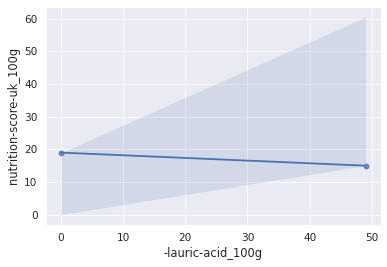

In [ ]:
sns.regplot(x="-lauric-acid_100g", y="nutrition-score-uk_100g", data=food_df_clean) #we observe a strict linear relation

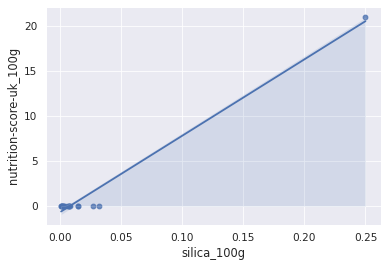

In [ ]:
sns.regplot(x="silica_100g", y="nutrition-score-uk_100g", data=food_df_clean) #we observe a strict linear relation

## Countries Information

As shown below, we can see that most products in the dataset are from US and France. So we set our focus on these two countries for many of the rest parts of within this project.

In [ ]:
# We will use 'countries_en' column to see countries
countries_top_8_df = food_df_clean['countries_en'].value_counts().head(8).to_frame()
countries_top_8 = countries_top_8_df.style.background_gradient(cmap='Reds')
countries_top_8

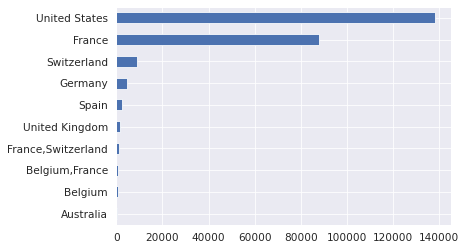

In [ ]:
# show that US and France have more data
# the difference is significant
food_df_clean['countries_en'].value_counts()[:10][::-1].plot.barh()

Here we can tell that products from United States composes a major part of this dataset. We hence set our focus on US products.

## World Food Product Categories


From the wordcloud below, we noticed some prominent keyword, including "plant-based" and "sugar", which we decided to further explore.

In [ ]:
def count_words(df, colonne = 'categories_en'):
    list_words = set()
    for word in df[colonne].str.split(','):
        if isinstance(word, float): continue
        list_words = set().union(word, list_words)       
    return list(list_words)

In [ ]:
category_keys = count_words(food_df_clean, 'categories_en')

In [ ]:
count_keyword = dict()
for index, col in food_df_clean['categories_en'].iteritems():
    if isinstance(col, float): continue
    for s in col.split(','):
        if s in count_keyword.keys():
            count_keyword[s] += 1
        else:
            count_keyword[s] = 1

keyword_census = []
for k,v in count_keyword.items():
    keyword_census.append([k,v])
keyword_census.sort(key = lambda x:x[1], reverse = True)

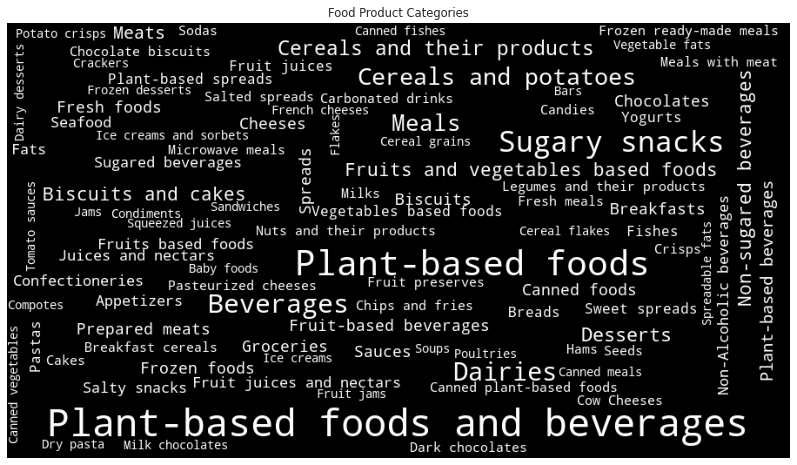

In [ ]:
from wordcloud import WordCloud

words = dict()
trunc_occurences = keyword_census[0:100]
for s in trunc_occurences:
    words[s[0]] = s[1]

wordcloud = WordCloud(width=900,height=500, background_color='black', 
                      max_words=95,
                      color_func = lambda *args, **kwargs: "white")
wordcloud.generate_from_frequencies(words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Food Product Categories")
plt.show()

##US Product Names Overview

In this part, we are interested in the product names and want to get an overall impression of them. We limit our scope to products of United States, for the sake of reading convenience.

In [ ]:
#select US products
us_food_names = food_df_clean[food_df_clean['countries_en']=='United States']
us_food_names = us_food_names[['product_name', 'categories_en']].dropna(subset=['categories_en'])

For the purpose of generating wordclouds, we import relevant libraries and create the function to tokenize test contents for future use.

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from nltk.tokenize import word_tokenize

#function to tokenize text
def tokenize(content):
  alpha_only = []
  if not content:
      print('The text to be tokenized is a None type. Defaulting to blank string.')
      return alpha_only
  tokens = word_tokenize(str(content))
  for token in tokens:
    if token.isalpha() and token.lower() not in stopwords:
      alpha_only.append(token.lower())
  return alpha_only

###All Categories

We first examined all the products in United States.

In [ ]:
#get a flattened list of product names
product_name_list = us_food_names['product_name'].tolist()
product_names = [str(name) for name in product_name_list]

In [ ]:
from wordcloud import WordCloud

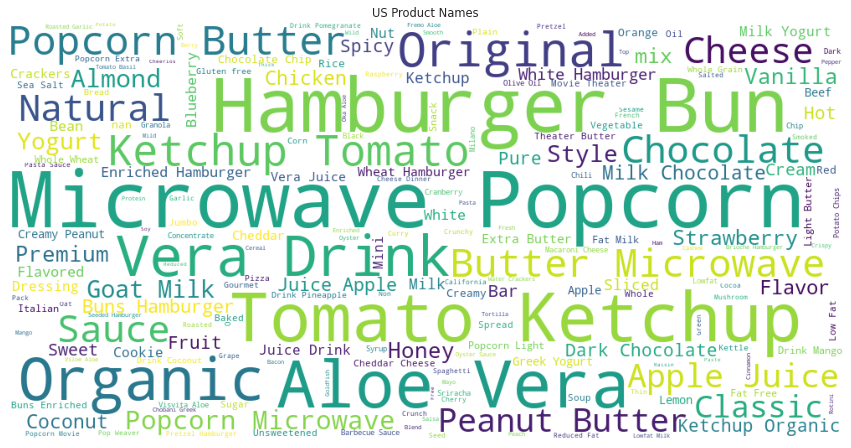

In [ ]:
#create a wordcloud
wordcloud = WordCloud(width = 1000, height = 500, background_color ='white').generate(' '.join(product_names))
#plot
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("US Product Names")
plt.show()

Frequent product names can be noticed from the above figure pretty intuitively. However, we wanted to get some more accurate information about them. Thus, we looked for statistical data and counted the number of appearences for each word.

In [ ]:
#tokenize:
us_food_names['tokenized_product_name'] = us_food_names['product_name'].apply(tokenize)

In [ ]:
#flatten:
tokens_lists = us_food_names['tokenized_product_name'].tolist()
tokens = [token for sublist in tokens_lists for token in sublist]

In [ ]:
#check most frequent words that appear in product names
from collections import Counter
hot_words_dict = Counter(tokens)
hot_words_df = pd.DataFrame(hot_words_dict, index=[0]).T #cast to dataframe
hot_words_df = hot_words_df.rename({0:'count'}, axis=1) #rename the column
hot_words_df = hot_words_df.sort_values(by=['count'], ascending=False)  #sort in descending order of count
hot_words = hot_words_df.head(5).style.background_gradient(cmap='Reds')  #get top 10 words
hot_words

We can infer from the analysis retults that food products listed below are most common in US:

1. Ketchup
2. Juice
3. Tomato, foods containing tomato or tomato-flavored
4. Popcorn
5. Microwaved foods

###Plant-based Category

According to the results in World Food Product Categories part, we have noticed the significance of plant-based category among the whole dataset. Thus in this part, we did extra analysis on plant-based products.

In [ ]:
#select products with description "plant-based" in their categories
us_plantbased_food = us_food_names[us_food_names['categories_en'].apply(lambda x: True if ("Plant-based" in x) else False)]

In [ ]:
#get a flattened list of product names
product_name_list = us_plantbased_food['product_name'].tolist()
product_names = [str(name) for name in product_name_list]

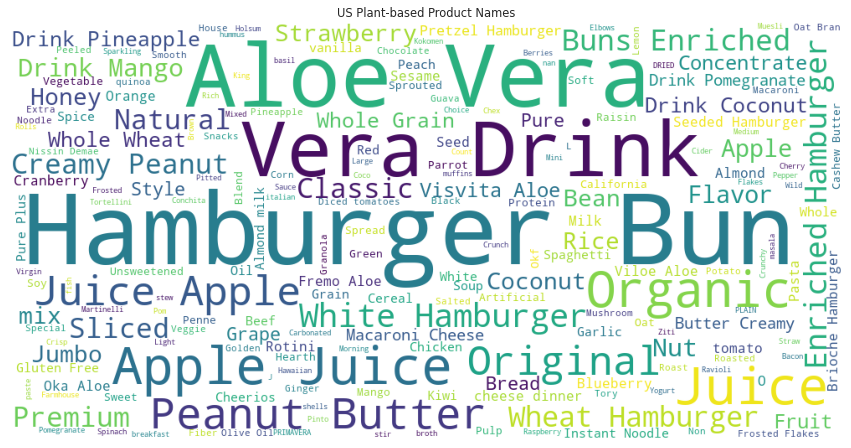

In [ ]:
#create a wordcloud
wordcloud = WordCloud(width = 1000, height = 500, background_color ='white').generate(' '.join(product_names))
#plot
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("US Plant-based Product Names")
plt.show()

Again, we sought more specific statistical data so we counted the number of appearences for each word.

In [ ]:
#tokenize:
us_plantbased_food['tokenized_product_name'] = us_plantbased_food['product_name'].apply(tokenize)

<ipython-input-75-df9473c9601b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_plantbased_food['tokenized_product_name'] = us_plantbased_food['product_name'].apply(tokenize)


In [ ]:
#flatten:
tokens_lists = us_plantbased_food['tokenized_product_name'].tolist()
tokens = [token for sublist in tokens_lists for token in sublist]

In [ ]:
#check most frequent words that appear in product names
from collections import Counter
hot_words_dict = Counter(tokens)
hot_words_df = pd.DataFrame(hot_words_dict, index=[0]).T #cast to dataframe
hot_words_df = hot_words_df.rename({0:'count'}, axis=1) #rename the column
hot_words_df = hot_words_df.sort_values(by=['count'], ascending=False)  #sort in descending order of count
hot_words = hot_words_df.head(5).style.background_gradient(cmap='Greens')  #get top 10 words
hot_words

We can infer from the above analysis that keywords listed below are most common in US plant-based foods:

1. Juice
2. Apple
3. Hamburger, hamburger ingredients, or hamberger accompaniments
4. Buns
5. Aloe, foods containing aloe or aloe-flavored

which are slightly different with the all-category products as a whole.

###Sugary Foods Category
According to the results in World Food Product Categories part, we have noticed the prominence sugary foods among the whole dataset. Thus in this part, we did extra analysis on sugary products.


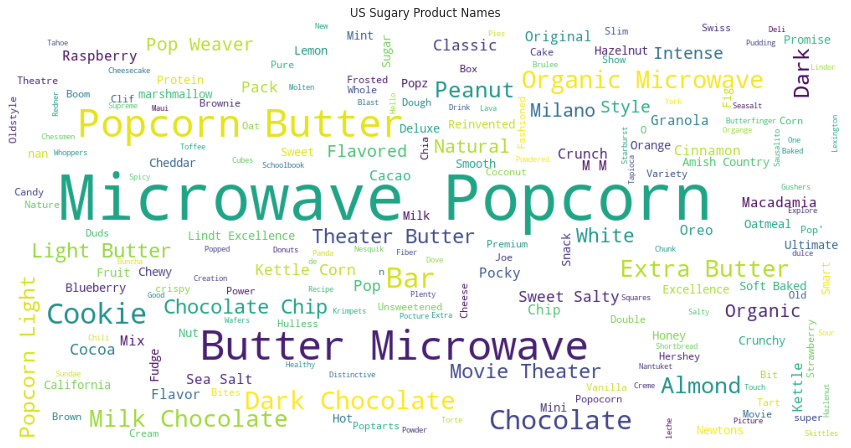

In [ ]:
#select products with description "Sugary" in their categories
us_sugary_food = us_food_names[us_food_names['categories_en'].apply(lambda x: True if ("Sugary" in x) else False)]

#get a flattened list of product names
product_name_list = us_sugary_food['product_name'].tolist()
product_names = [str(name) for name in product_name_list]

#create a wordcloud
wordcloud = WordCloud(width = 1000, height = 500, background_color ='white').generate(' '.join(product_names))
#plot
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("US Sugary Product Names")
plt.show()

In [ ]:
#tokenize:
us_sugary_food['tokenized_product_name'] = us_sugary_food['product_name'].apply(tokenize)

#flatten:
tokens_lists = us_sugary_food['tokenized_product_name'].tolist()
tokens = [token for sublist in tokens_lists for token in sublist]

#check most frequent words that appear in product names
from collections import Counter
hot_words_dict = Counter(tokens)
hot_words_df = pd.DataFrame(hot_words_dict, index=[0]).T #cast to dataframe
hot_words_df = hot_words_df.rename({0:'count'}, axis=1) #rename the column
hot_words_df = hot_words_df.sort_values(by=['count'], ascending=False)  #sort in descending order of count
hot_words = hot_words_df.head(5).style.background_gradient(cmap='Blues')  #get top 10 words
hot_words

<ipython-input-79-1f8999b68ed8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_sugary_food['tokenized_product_name'] = us_sugary_food['product_name'].apply(tokenize)


As shown above, we can see that popular sugary products in US are popcorn, butter and chocolate. 

# **Unsupervised Machine Learning - Clustering**




## K-means for three factors: Energy, Fat and Sugars

In this section, we want to use the unsupervised machine learning method that we acquire from class to observe how the data is naturally clustered. We will include clustering methods such as k-means, gaussian mixture models, as well as hierarchical methods followed by a short analysis of each. 

In the first part, we will use k-means clustering, which is thoroughly expained in our class. Essentially, We will include seven features, 'saturated-fat_100g','fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g','energy_100g' to observe how the products can be clustered with these seven well-recognized food indicators. 


First of all, we will create functions of create_features to prepoccess the dataframe, then we use run_pipeline to actually run k-means. After that, we will use the method of elbow to find the optimal number for k (the number of clusters). Finally, this part will end with visualizion of wordCloud designed for every clusters in order for readers to comprehend the concepts visually. 

In [ ]:
from numpy.random.mtrand import normal
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def create_features(df, unname, return_scaler):
    df = df[[
        'product_name','saturated-fat_100g','fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g','energy_100g' # or something else
        ]]
  
    df.dropna(how = 'all', axis = 0, inplace=True)
    df.fillna(0, inplace = True)
    names = df.product_name.tolist()
    df = df.drop(['product_name'], axis=1)
    x = df.values # numpy array
    scaler = preprocessing.StandardScaler()

    x_scaled = scaler.fit_transform(x)
    if unname:
      initial_len = len(names)
      names = []
      for i in range(initial_len):
        names.append(" ")

    if return_scaler:
      return names, pd.DataFrame(x_scaled), scaler

    return names, pd.DataFrame(x_scaled)




def run_pipeline(k, names, X_norm, pca_component):
    pca = PCA(n_components = 3, random_state = 0) # 3D PCA for the plot
    reduced = pd.DataFrame(pca.fit_transform(X_norm))

    kmeans = KMeans(n_clusters=k, random_state = 0)
    
    # Make this student todos 
    # fit the input data
    kmeans = kmeans.fit(reduced)
    # get the cluster labels
    labels = kmeans.predict(reduced)
    # centroid values
    centroid = kmeans.cluster_centers_
    # cluster values
    clusters = kmeans.labels_.tolist()

    reduced['cluster'] = clusters
    reduced['name'] = names
    reduced.columns = ['x', 'y', 'z', 'cluster', 'name']


    if(pca_component):
      return reduced, pca.components_

    return reduced



In [ ]:
names, X_norm = create_features(food_df_clean, unname=False, return_scaler = False)
# first, we choose our cluster number to be 15 (we will later re-choose another cluster number)
k = 15
km = run_pipeline(k, names, X_norm, False)
# do a groupby to see how our clusters perform
km.groupby('cluster').count().sort_values('x', ascending = False)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


x      y      z   name
cluster                            
5        58696  58696  58696  58696
8        32953  32953  32953  32953
9        29868  29868  29868  29868
1        21134  21134  21134  21134
14       18326  18326  18326  18326
2        16834  16834  16834  16834
7        16736  16736  16736  16736
11       13649  13649  13649  13649
0        12541  12541  12541  12541
12       12036  12036  12036  12036
4         9630   9630   9630   9630
10        8814   8814   8814   8814
13        1167   1167   1167   1167
3            1      1      1      1
6            1      1      1      1

In [ ]:
km[km['cluster'] ==3 ]

x         y           z  cluster           name
114630 -0.684731  4.123665  499.695361        3  Prickly Syrup

In [ ]:
km[km['cluster'] ==6 ]

x          y        z  cluster  \
248171  241.041681  77.732659  0.63271        6   

                                      name  
248171  Nusco, Chocolate Spread, Chocolate

From the previous table, we can see that if we aggressively set cluster number (i.e. k) to be 15. There will be some outliers in group 3, and group 6. We will drop these data. 

In [ ]:
food_df_clustering = food_df_clean.drop(food_df_clean[food_df_clean.product_name.apply(lambda x: x in {'Nusco, Chocolate Spread, Chocolate', 'Prickly Syrup'})].index)

### Choosing cluster number

There is a better approach to decide the cluster number than choosing them manually, which is the elbow method. In order to use the notion of elbow method, we consider the notion of distortion, which is simply the sum of mean squared error of each data case to it assigned centroid. The distortion serves as a criteria to decide a better fit. The smaller the distortion is, the better fit our model will be. Though, as the clustors number increases, the distortion will corresponding decreases due to its nature. It is the elbow part (the part where distortion smoothes its decreasing rate with regard to the increase of clustor number)that we will decide on our final cluster data.

In [ ]:
def deciding_k(K, names, X_norm):
    pca = PCA(n_components = 3, random_state = 0) # 2D PCA for the plot
    reduced = pd.DataFrame(pca.fit_transform(X_norm))
  

    #compute the distortion
    Sum_of_squared_distances = []

    for k in K:
      kmeans = KMeans(n_clusters=k, max_iter = 100, random_state = 0)  
     
      # fit the input data
      kmeans = kmeans.fit(reduced)
      # get the cluster labels
      labels = kmeans.predict(reduced)
      # centroid values
      centroid = kmeans.cluster_centers_
      # cluster values
      clusters = kmeans.labels_.tolist()
      Sum_of_squared_distances.append(kmeans.inertia_)

    return Sum_of_squared_distances

In [ ]:
K = range(1,15)
# notice that we are using food_df_clustering, which already has outliers being cleaned
names, X_norm = create_features(food_df_clustering, unname=False, return_scaler= False)
distortion = deciding_k(K, names, X_norm)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


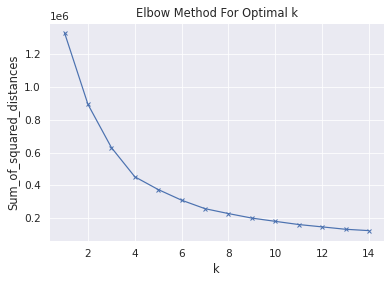

In [ ]:
plt.plot(K, distortion, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

As we saw from the graph, the area of where 8, 9 or 10 located is exactly an "elbow", hence a greater cluster number. In this way, we can manually pick a number for our choice. And 8 will be the lucky number ✋. 

In [ ]:
# 8 is our chosen cluster number 
k = 8
names, X_norm, scaler_returned= create_features(food_df_clustering, unname = False, return_scaler = True)
km, pca_component_analysis = run_pipeline(k, names, X_norm, True)
# do a groupby to see how our clusters perform
km.groupby('cluster').count().sort_values('x', ascending = False)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


x      y      z   name
cluster                            
5        75797  75797  75797  75797
7        49177  49177  49177  49177
1        39981  39981  39981  39981
2        37642  37642  37642  37642
6        25474  25474  25474  25474
0        20383  20383  20383  20383
4         3918   3918   3918   3918
3           12     12     12     12

Let us observe the distribution of data from these 8 clusters by barplots first.

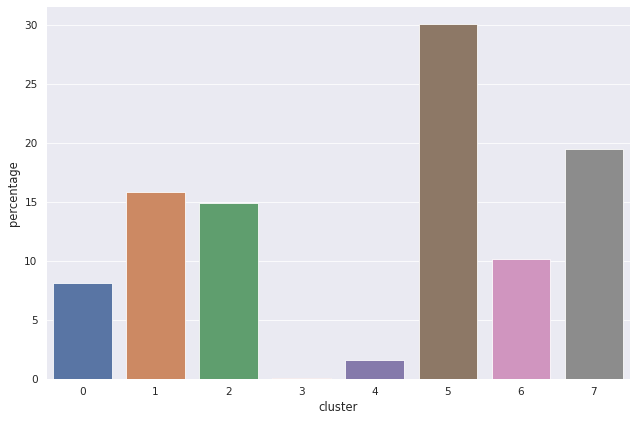

In [ ]:
clusters_dist = km.groupby('cluster').count().sort_values('x', ascending = False)
clusters_dist.reset_index(drop = False, inplace = True)
clusters_dist['percentage'] = (clusters_dist.x/clusters_dist.x.sum())*100
sns.catplot(x= 'cluster', y = 'percentage', hue = 'cluster', data = clusters_dist, kind = 'bar', height = 6, aspect = 1.5, dodge = False )


If you are wondering why the cluster 3 has too little data cases, we can check its principal components value by printing it out, which we will observe that cluster 3 has an extreme high z value. To analyze what the z value is, we can print out he PCA components to see what features in our seven indicators are culpable for resulting such a large z value.

In [ ]:
km[km['cluster'] ==3]

x         y           z  cluster  \
872     1.457532  4.184339   65.561732        3   
18378  -3.259688  5.819412  153.036017        3   
45563  -1.090569  8.078373  135.505608        3   
52897  -1.282508  3.138771   82.728159        3   
52906  -1.078030  2.228224   64.668667        3   
73903   1.435976  4.184278   99.267616        3   
82608  -2.239048  7.352175  184.904248        3   
83629  -2.296389  3.377494   85.774258        3   
109516 -4.848452  9.983298  229.534226        3   
126568 -2.217930  6.878702  125.750153        3   
251043  0.252400  6.658777  141.942949        3   
251747  1.545593  5.826117   93.350142        3   

                                                     name  
872                                   Dill Pickle Cashews  
18378                             Original Barbecue Sauce  
45563                                String Cheese Snacks  
52897   Rhodes, Bake N Serv, Cinnamon Rolls With Cream...  
52906   Rhodes, Bake N Serv, Cinnamon Rolls With Cream...  
73903   Swiss Recipe Smoked Almonds & Sea Salt In Dark...  
82608                              Bastoncini Whole Wheat  
83629           Small Potato Dumplings, Potato Gnocchetti  
109516                                   Sauce & Marinade  
126568            Sausage Patties, Veggie Sausage Patties  
251043                                               Lays  
251747                               Smooth Peanut Butter

In [ ]:
pca_component_analysis

array([[ 0.4806822 ,  0.52333173,  0.24727546,  0.21778824,  0.18020913,
        -0.01307274,  0.59484907],
       [ 0.21941782,  0.26750658, -0.59014841, -0.60150956,  0.40447999,
         0.04342145, -0.06868523],
       [-0.04335152, -0.02762534,  0.07001003,  0.01422985,  0.06312721,
         0.99372995,  0.02773702]])

As we can see from the last segment of code, in the third row of the array (which is a explained analysis of what constitutes "z" value), the last second entry (column = 5) contributes the most, 0.99528263, which is actually **salt**. 

By further printing out the seven indicators of all the data cases in assigned to cluster 3, we can see that these values, undoubtly has a **too large value of salt** that they comprises of a unique cluster for them. 

In the next step, the dataframe printed below joins the principal components (x, y, z) of the data cases we used to do k-means with its original seven indicators   ( 'saturated-fat_100g', 'fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'energy_100g').

In [ ]:
pca_original_combined= km[km['cluster'] ==3].reset_index(drop = False).merge(pd.DataFrame(scaler_returned.inverse_transform(X_norm)).reset_index(drop = False), on = 'index')
pca_original_combined

index         x         y           z  cluster  \
0      872  1.457532  4.184339   65.561732        3   
1    18378 -3.259688  5.819412  153.036017        3   
2    45563 -1.090569  8.078373  135.505608        3   
3    52897 -1.282508  3.138771   82.728159        3   
4    52906 -1.078030  2.228224   64.668667        3   
5    73903  1.435976  4.184278   99.267616        3   
6    82608 -2.239048  7.352175  184.904248        3   
7    83629 -2.296389  3.377494   85.774258        3   
8   109516 -4.848452  9.983298  229.534226        3   
9   126568 -2.217930  6.878702  125.750153        3   
10  251043  0.252400  6.658777  141.942949        3   
11  251747  1.545593  5.826117   93.350142        3   

                                                 name      0      1      2  \
0                                 Dill Pickle Cashews   8.57  45.71  28.57   
1                             Original Barbecue Sauce   0.00   0.00  36.67   
2                                String Cheese Snacks  12.50  18.75   4.17   
3   Rhodes, Bake N Serv, Cinnamon Rolls With Cream...   2.70   8.11  48.65   
4   Rhodes, Bake N Serv, Cinnamon Rolls With Cream...   2.11   7.04  50.70   
5   Swiss Recipe Smoked Almonds & Sea Salt In Dark...  14.29  40.48  45.24   
6                              Bastoncini Whole Wheat   1.72   5.17  75.86   
7           Small Potato Dumplings, Potato Gnocchetti   0.00   0.61  36.36   
8                                    Sauce & Marinade   0.00   0.00  13.33   
9             Sausage Patties, Veggie Sausage Patties   0.00  12.86   8.57   
10                                               Lays  13.50  34.00  51.60   
11                               Smooth Peanut Butter  11.60  48.10  17.70   

        3      4           5       6  
0    5.71  17.14   870.85678  2389.0  
1   16.67   0.00  2032.00000   628.0  
2    0.00  25.00  1799.16582  1222.0  
3    9.46   5.41  1098.37728  1243.0  
4   11.27   5.63   858.59112  1238.0  
5   33.33   9.52  1318.38192  2322.0  
6    3.45  10.34  2452.41318  1586.0  
7    8.48   4.85  1139.15190   686.0  
8    6.67   0.00  3048.00000   280.0  
9    0.00  20.00  1669.14322   958.0  
10   2.00   7.80  1884.68000  2276.0  
11  11.70  22.60  1239.52000  2510.0

This is a quick check (only involve some products which have unique product name) to reassure that the column 5 is exactly the column for salt_100g. And these product do have a high-salt property such that they are being clustered together by k-means.

In [ ]:
food_df_clustering[food_df_clustering['product_name'].apply(lambda x: x in {'Crispy Fried Onions, White Cheddar','String Cheese Snacks','Bastoncini Whole Wheat','Small Potato Dumplings, Potato Gnocchetti','Chiles Habaneros Rojos','Sausage Patties, Veggie Sausage Patties',})] \
[['product_name','saturated-fat_100g','fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g','energy_100g']]

product_name  saturated-fat_100g  \
58409                        String Cheese Snacks               12.50   
105824                     Bastoncini Whole Wheat                1.72   
107178  Small Potato Dumplings, Potato Gnocchetti                0.00   
162397    Sausage Patties, Veggie Sausage Patties                0.00   

        fat_100g  carbohydrates_100g  sugars_100g  proteins_100g   salt_100g  \
58409      18.75                4.17         0.00          25.00  1799.16582   
105824      5.17               75.86         3.45          10.34  2452.41318   
107178      0.61               36.36         8.48           4.85  1139.15190   
162397     12.86                8.57         0.00          20.00  1669.14322   

        energy_100g  
58409        1222.0  
105824       1586.0  
107178        686.0  
162397        958.0

### WordCloud for selected clusters

In [ ]:
import nltk
nltk.__version__

'3.7'

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
nltk.corpus.stopwords

<WordListCorpusReader in '/root/nltk_data/corpora/stopwords'>

In [ ]:
# TODO: tokenize and flatten
def tokenize_content(content):
  tokens = nltk.word_tokenize(content)
  alpha_words = [word.lower() for word in tokens if word.isalpha()]
  removed_alpha_words = [word for word in alpha_words if word not in stopwords]

  return  removed_alpha_words

In [ ]:
from wordcloud import WordCloud

In [ ]:
#create a wordcloud for different clusters
def create_wordcloud(df_series, clusterNum):
  # TODO: tokenize and flatten
  df_series = df_series.astype(str)
  name = df_series.tolist()
  top_tokens_list = [] 


  for item in name:
    top_tokens_list.append(tokenize_content(item))

  top_tokens = [item for sublist in top_tokens_list for item in sublist]

  # make a word cloud for top tokens 

  plt.subplots(figsize = (10,5))

  wordcloud = WordCloud (
                    background_color = 'white',
                    width = 300,
                    height = 200
                        ).generate(' '.join(top_tokens))
  plt.imshow(wordcloud) # image show
  plt.axis('off') # to off the axis of x and y
  plt.title('wordcloud for cluster ' + clusterNum) # to off the axis of x and y
  plt.show()

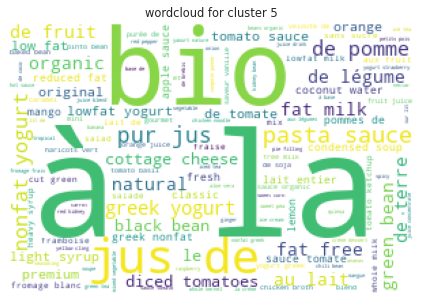

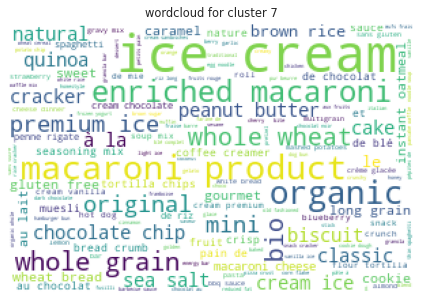

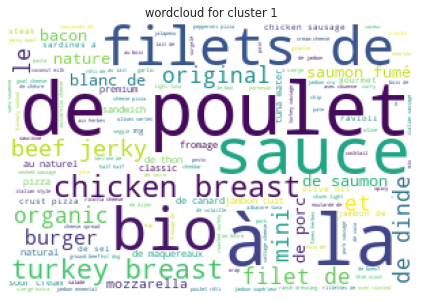

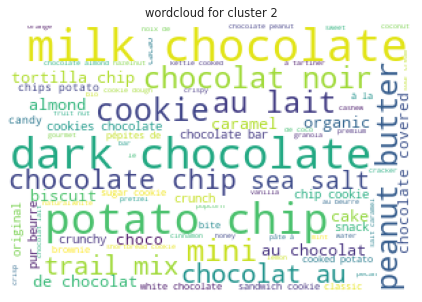

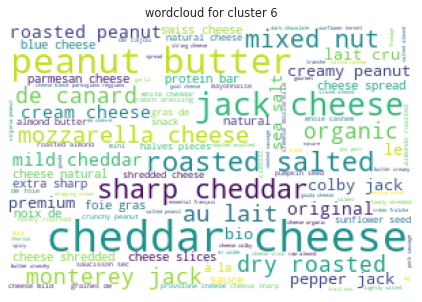

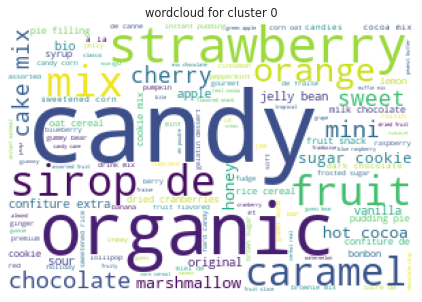

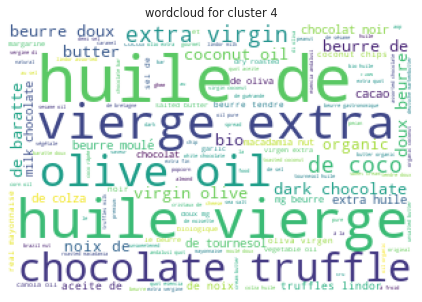

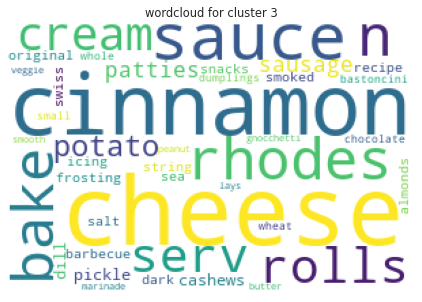

In [ ]:
#for all the clusters that in km(not outliers)
for clusterNum in clusters_dist.cluster:
  
  cluster_df = km[km['cluster'] == clusterNum]

  create_wordcloud(cluster_df['name'], str(clusterNum))


A little guess:

Cluster 0: candy/strawberry/honey **sweets**

Cluster 1: beef jerky/protein bar **protein products?**

Cluster 2: dark chocolate/potato chip **snacks?**

Cluster 3: **salty!!**

Cluster 4: olive oil/ oil **oily**

Cluster 5: sauce/black beans/organic **organic**

Cluster 6: cheese/peanut butter/butter **high energy**

Cluster 7: ice cream/macaroni/bread **high carbo products?**


## Hierchical Clustering

In the second section of our clustering, we apply agglomerative clustering which is a type of hierarchical clustering. Typically, hierarchical clustering gives us  insights on data relations directly through dendregrams. However, one of its disadvantages is that it is not feasible for us to determine the cluster numbers like k-means.

For the sake of visual clarity and running time, we will only choose 100 data cases when creating features to pass into our models. Like the previous clustering method, we choose seven renowned food indicators as our features.

In [ ]:
from sklearn.preprocessing import normalize

def create_features(df):
    df = df[[
        'saturated-fat_100g','fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g','energy_100g' # or something else
        ]].sample(1000, random_state=66)
  
    df.dropna(how = 'all', axis = 0, inplace=True)
    df.fillna(0, inplace = True)
    x = df.values # numpy array
    scaler = preprocessing.StandardScaler()

    #scale the data
    x_scaled = scaler.fit_transform(x)
    #normalize the data
    df_normalized = normalize(x_scaled)

    # Reduce the dimensionality of data to 3 features

    pca = PCA(n_components=3)
    df_pca = pca.fit_transform(df_normalized)
    df_pca = pd.DataFrame(df_pca)
    df_pca.columns = ['P1', 'P2', 'P3']



    return pd.DataFrame(df_pca)



In [ ]:
X_hier_clustering = create_features(food_df_clean)

Aftering prepocessing our data, it is time to pass them into our model of hierchical clustering with help of scipy.

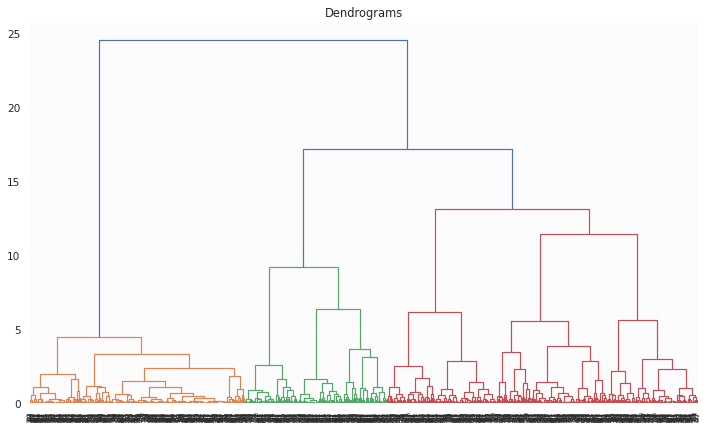

In [ ]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(12, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_hier_clustering, method='ward'))


### Choosing cluster number

From this graph, the x-axis are the samples and the y-axis are the distance between the samples. The vertical line that has maximum distance is the blue line and hence we can decide a threshold within the blue line and cut the dendrogram:

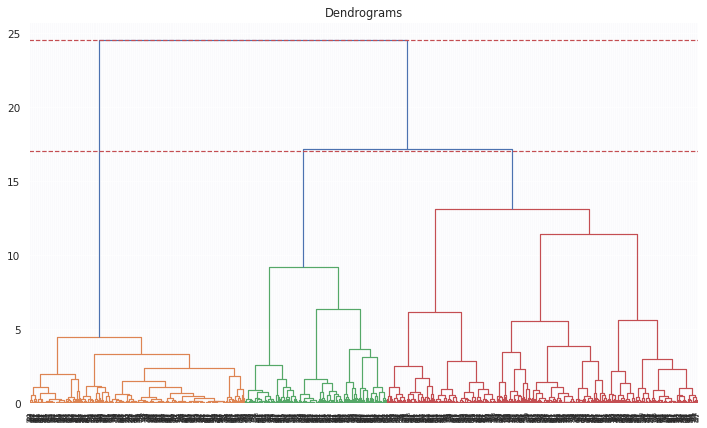

In [ ]:
plt.figure(figsize=(12, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_hier_clustering, method='ward'))
plt.axhline(y=17, color='r', linestyle='--')
plt.axhline(y=24.5, color='r', linestyle='--')

The optimal number of clusters is equal to the number of vertical lines going through the horizontal line. We can observe that the blue line only has two vertical lines across itself. So the maximum cluster to choose within this 100 data cases will be **2**.

In [ ]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
cluster.fit_predict(X_hier_clustering)
labels = cluster.labels_

In [ ]:
labels

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,

In [ ]:
X_hier_clustering

P1        P2        P3
0    0.491977 -0.655397 -0.567336
1    0.738905 -0.641957 -0.339551
2   -0.829709 -0.234424  0.176302
3   -0.627330  0.473811 -0.294184
4    0.898118 -0.523744  0.107580
..        ...       ...       ...
995 -0.859244 -0.066801  0.150273
996 -0.855189 -0.058041  0.107533
997 -0.141489  0.213949 -0.125632
998 -0.806369 -0.308152  0.184112
999  0.671847 -0.731080 -0.259104

[1000 rows x 3 columns]

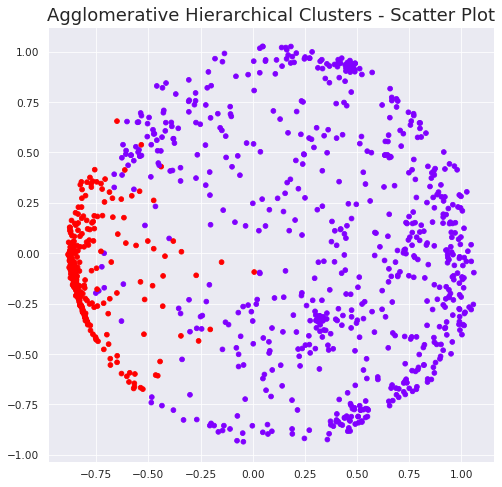

In [ ]:
plt.figure(figsize =(8, 8))
plt.scatter(X_hier_clustering['P1'], X_hier_clustering['P2'], c = labels, cmap ='rainbow')
plt.title("Agglomerative Hierarchical Clusters - Scatter Plot", fontsize=18)
plt.show()

## Gaussian Mixture Models

Gaussian Mixture Model is very similar to the application of k-means. However, it is more advanced than k-means. In k-means, we usually choose the centroids only to and calculate the distance between the centroids and data to assign clusters. 

However, it doesn't take into account of circumstances when multiple centroids might have same centroids or the centroid is not enough to represent the clusters.

Therefore, in Gaussian Mixture Models, we have more parameters when we are building clusters: the mean and the covariance, to describe the position and shape of each cluster. First, we start with assigning random parameters to each clusters ( (ie the mean, covariance and weighting). When assigning data to clusters, we calculate the likehood of each data belonging to a cluster according to current data. Then, we recalculate the cluster's parameters until it reaches a stable condition. 

First, we start by creating features for this model.

In [ ]:
# seven food indicators for modelling
filtered_columns = ['saturated-fat_100g','fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g','energy_100g']

# Cleaning if any values are empty in a row
food_df_clean["isempty"] = np.where(food_df_clean[filtered_columns].isnull().sum(axis=1) >= 1, 1, 0)
# Estimation of cleaning proportion
percentage = (food_df_clean.isempty.value_counts()[1] / food_df_clean.shape[0]) * 100
print("Percentage of incomplete tables: " + str(percentage))
print(food_df_clean.isempty.value_counts())
# Cleaning
df_cleaned = food_df_clean[food_df_clean.isempty==0]
# Check if cleaning is successful
df_cleaned.isnull().sum()

Percentage of incomplete tables: 6.419851895288622
0    236186
1     16203
Name: isempty, dtype: int64


code                            0
url                             0
creator                         1
created_t                       0
created_datetime                1
                            ...  
cocoa_100g                 234965
carbon-footprint_100g      235954
nutrition-score-fr_100g         0
nutrition-score-uk_100g         0
isempty                         0
Length: 146, dtype: int64

Let's apply the model. There are many ways that we can choose cluster number for GMM, such as BOC/AOC. For the sake of simplicity and running time, we will choose the cluster number to be the same as k-means cluster number **6**.

In [ ]:
%%time
from sklearn.mixture import GaussianMixture

#creatig features
features = ['saturated-fat_100g','fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g','energy_100g']
X_train = df_cleaned[features].values

#choosing cluster number
n_clusters = 8

#create the model
max_iter = 100
model = GaussianMixture(n_components=n_clusters, covariance_type="full", n_init = 5, max_iter = max_iter)
#fit model on data
model.fit(X_train)

#predict cluster number for the date
results = df_cleaned
results["cluster"] = model.predict(X_train)

CPU times: user 2min 50s, sys: 1min 48s, total: 4min 38s
Wall time: 2min 42s


<timed exec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


After running the model, let us visualize these clusters by creating wordcould for them.

In [ ]:
%%time
import math
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def make_word_cloud(data, cluster, subplotax, title):
    # Get words from the product name 
    words = data[data.cluster==cluster]["product_name"].apply(lambda l: l.lower().split() if type(l) == str else '')
    # Add to a pandas series
    cluster_words=words.apply(pd.Series).stack().reset_index(drop=True)
    # Split and join
    text = " ".join(w for w in cluster_words)

    # Create and generate a word cloud image:
    wordcloud = WordCloud(max_font_size=30, max_words=30, background_color="white", colormap="YlGnBu").generate(text)

    # Display the generated image:    
    subplotax.imshow(wordcloud, interpolation='bilinear')
    subplotax.axis("off")
    subplotax.set_title(title,fontweight="bold", size=20)
    return subplotax


CPU times: user 36 µs, sys: 12 µs, total: 48 µs
Wall time: 28.4 µs


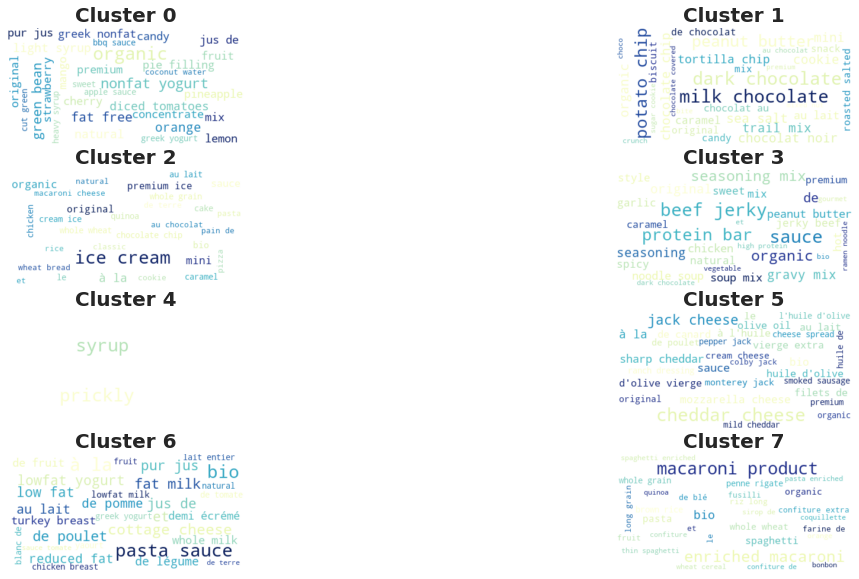

In [ ]:
rows = math.ceil(n_clusters/2)
fig, ax = plt.subplots(rows,2, figsize=(20,10))
for m in range(rows):
    for n in range(2):
        cluster = m*2+ n
        title = "Cluster " + str(cluster) 
        make_word_cloud(results, cluster, ax[m,n], title)

In [ ]:
for cluster in range(0,n_clusters):
    display("Cluster "+str(cluster))
    display(results[results['cluster'] == cluster][features].describe())

'Cluster 0'

saturated-fat_100g      fat_100g  carbohydrates_100g   sugars_100g  \
count        3.716600e+04  3.716600e+04        37166.000000  37166.000000   
mean         5.219825e-07  6.322983e-07           31.572604     21.732598   
std          2.262825e-05  2.616074e-05           33.303952     27.103005   
min          0.000000e+00  0.000000e+00            0.000000     -1.200000   
25%          0.000000e+00  0.000000e+00            6.560000      2.700000   
50%          0.000000e+00  0.000000e+00           13.330000      9.500000   
75%          0.000000e+00  0.000000e+00           65.000000     33.800000   
max          1.000000e-03  2.100000e-03          104.000000    104.000000   

       proteins_100g     salt_100g   energy_100g  
count   37166.000000  37166.000000  37166.000000  
mean        1.573138      0.495232    559.990116  
std         2.652923      1.006694    567.731015  
min         0.000000      0.000000      0.000000  
25%         0.000000      0.000000    138.000000  
50%         0.010000      0.058420    254.000000  
75%         2.030000      0.535940   1151.000000  
max        20.000000      7.983220   1929.000000

'Cluster 1'

saturated-fat_100g      fat_100g  carbohydrates_100g   sugars_100g  \
count        54788.000000  54788.000000        54788.000000  54788.000000   
mean             9.406437     26.720341           55.832413     29.023861   
std              7.780894     13.863928           17.295868     20.669841   
min              0.000000      0.000000            0.000000      0.000000   
25%              3.570000     17.650000           48.480000      6.670000   
50%              7.140000     25.000000           58.000000     30.950000   
75%             14.290000     35.000000           67.300000     45.000000   
max             90.000000     85.710000          100.000000    145.000000   

       proteins_100g     salt_100g   energy_100g  
count   54788.000000  54788.000000  54788.000000  
mean        8.420577      0.763898   2054.256818  
std         5.930204      0.739134    315.456537  
min         0.000000      0.000000    860.000000  
25%         4.760000      0.177800   1824.000000  
50%         6.900000      0.576580   2084.000000  
75%        10.000000      1.100000   2259.000000  
max        35.710000      4.234180   3435.000000

'Cluster 2'

saturated-fat_100g      fat_100g  carbohydrates_100g   sugars_100g  \
count        53745.000000  53745.000000        53745.000000  53745.000000   
mean             3.497099      9.034182           35.337799      9.883352   
std              3.543944      5.770546           21.428237     10.393267   
min              0.000000      0.000000            0.000000     -6.250000   
25%              0.600000      4.550000           18.000000      2.000000   
50%              2.460000      8.100000           29.630000      4.650000   
75%              5.500000     12.500000           51.060000     18.000000   
max             23.210000     39.290000          100.000000     60.000000   

       proteins_100g     salt_100g   energy_100g  
count   53745.000000  53745.000000  53745.000000  
mean        6.870932      0.954483   1053.726216  
std         3.890324      0.695266    432.259519  
min         0.000000      0.000000      0.000000  
25%         3.750000      0.406400    703.000000  
50%         6.600000      0.900000   1025.000000  
75%         9.500000      1.300000   1431.000000  
max        24.710000      4.500000   2912.000000

'Cluster 3'

saturated-fat_100g      fat_100g  carbohydrates_100g   sugars_100g  \
count        12638.000000  12638.000000        12638.000000  12638.000000   
mean             3.937733     13.245757           33.287652     11.654669   
std              6.374130     15.352515           25.275693     15.379047   
min              0.000000      0.000000            0.000000    -17.860000   
25%              0.000000      1.000000           13.330000      0.000000   
50%              1.200000      8.070000           28.120000      5.710000   
75%              5.500000     20.930000           52.170000     17.860000   
max            100.000000    200.000000          165.000000    100.000000   

       proteins_100g     salt_100g   energy_100g  
count   12638.000000  12638.000000  12638.000000  
mean       14.341334     10.193076   1303.228900  
std        16.986290     57.819147    776.221013  
min        -3.570000      0.000000      0.000000  
25%         0.700000      0.700000    837.000000  
50%         8.300000      2.710090   1356.000000  
75%        21.900000      7.886065   1674.000000  
max       305.000000   3048.000000  22000.000000

'Cluster 4'

saturated-fat_100g  fat_100g  carbohydrates_100g  sugars_100g  \
count                 1.0       1.0                1.00         1.00   
mean                  0.0       0.0               72.15        53.16   
std                   NaN       NaN                 NaN          NaN   
min                   0.0       0.0               72.15        53.16   
25%                   0.0       0.0               72.15        53.16   
50%                   0.0       0.0               72.15        53.16   
75%                   0.0       0.0               72.15        53.16   
max                   0.0       0.0               72.15        53.16   

       proteins_100g  salt_100g  energy_100g  
count            1.0        1.0          1.0  
mean             0.0    64312.8       1218.0  
std              NaN        NaN          NaN  
min              0.0    64312.8       1218.0  
25%              0.0    64312.8       1218.0  
50%              0.0    64312.8       1218.0  
75%              0.0    64312.8       1218.0  
max              0.0    64312.8       1218.0

'Cluster 5'

saturated-fat_100g      fat_100g  carbohydrates_100g   sugars_100g  \
count        34461.000000  34461.000000        34461.000000  34461.000000   
mean            11.386662     28.868170            2.741716      1.280078   
std             11.106322     21.690508            2.944794      1.834844   
min              0.000000      0.000000            0.000000     -0.100000   
25%              3.400000     15.000000            0.200000      0.000000   
50%              9.260000     25.000000            1.800000      0.500000   
75%             16.800000     32.140000            3.800000      1.900000   
max            100.000000    101.000000           25.000000     10.900000   

       proteins_100g     salt_100g   energy_100g  
count   34461.000000  34461.000000  34461.000000  
mean       14.591090      1.826570   1373.675094  
std        10.044153      1.313086    742.932495  
min         0.000000      0.000000      0.000000  
25%         4.100000      1.000000    856.000000  
50%        16.000000      1.633220   1223.000000  
75%        22.000000      2.382520   1644.000000  
max        62.700000      8.300000   4184.000000

'Cluster 6'

saturated-fat_100g      fat_100g  carbohydrates_100g   sugars_100g  \
count        31667.000000  31667.000000        31667.000000  31667.000000   
mean             0.767257      1.876309            8.090548      5.600724   
std              0.850240      1.482678            5.478776      5.071025   
min              0.000000      0.000000            0.000000     -0.800000   
25%              0.040000      0.500000            4.000000      1.200000   
50%              0.460000      1.600000            7.500000      4.400000   
75%              1.250000      2.920000           12.000000      9.500000   
max              4.290000      9.090000           28.800000     25.000000   

       proteins_100g     salt_100g   energy_100g  
count   31667.000000  31667.000000  31667.000000  
mean        5.442604      0.522750    301.116268  
std         6.605865      0.563277    134.809365  
min         0.000000      0.000000      0.000000  
25%         1.020000      0.100000    197.000000  
50%         3.100000      0.210000    289.000000  
75%         6.000000      0.860000    406.000000  
max        37.650000      2.720340    983.000000

'Cluster 7'

saturated-fat_100g      fat_100g  carbohydrates_100g   sugars_100g  \
count        11720.000000  11720.000000        11720.000000  11720.000000   
mean             0.160269      1.270936           66.469170     19.251017   
std              0.222502      0.995760           18.916571     26.449786   
min              0.000000      0.000000            0.000000      0.000000   
25%              0.000000      0.500000           60.000000      1.300000   
50%              0.030000      1.190000           72.000000      3.570000   
75%              0.300000      1.790000           76.900000     39.000000   
max              1.300000      6.100000          136.000000    134.000000   

       proteins_100g     salt_100g   energy_100g  
count   11720.000000  11720.000000  11720.000000  
mean        7.447214      0.022306   1285.557938  
std         6.301142      0.031880    372.866718  
min         0.000000      0.000000      0.000000  
25%         0.700000      0.000000   1075.000000  
50%         7.400000      0.010000   1464.000000  
75%        12.500000      0.030000   1506.000000  
max        32.300000      0.200000   2510.000000

Most of the clusters are quite clear and similar to what we have in k-means, here's a little fun guess of me ✨✨:

Cluster 0: dark chocolate/potato chip **snacks?**
(high enerygy, high carbo, high sugar, high fat)

Cluster 1: nonfat yogurt/mango/orange **healthy food?**
(low everything)

Cluster 2: macaroni/spagetti/rice/grain **carbo!**
(high carbo, high energy)

Cluster 3: strawberry/mango/nonfat yougurt **super healthy food and fruits**
(low everything, even lower than cluster 1)

Cluster 4: cheese/olive oil/butter **For cuisine?**
(high enerygy, high carbo, high sugar, high fat, high protein)

chicken/turkey breast/tomato sauce **meat&soup?**
(low enerygy, low carbo, low sugar, low fat, median protein)

Cluster 5: Prickly and syrup! which is exactly what we dropped in k-means!

Cluster 6: ice cream/cake/biscuit **bakings?**
(high enerygy, high carbo, low sugar, low fat)

Cluster 7: beef jerky/protein bar **protein products?**
(medium energy, high carbo, high sugar, high protein, medium fat)

#**Supervised Machine Learning**

In this section, we used supervised machine learning methods to map functions from features to selected targets. We included multiple methods for predictions of both categorical and continuous values, for specific topic that is meaningful and worths analysis. Within each part, we tried different methods, examined their performance and further improved them. For each part, we used different preprocessing methods to deal with different problems, including multicollinearity, missing data, and imbalance in the training set. During this process, we also did some comparisons to better understand the models and methods we were using.

We first conducted binary classifications for plant-based foods and sugary foods, as we noticed their importance among the whole dataset in our previous sections. In these two parts, we applied common methods for classification, including Logistic Regression, Decision Trees, Random Forests, and Neural Network.



Then we paid attention to an essential content of food products, energy. For this feature, we decided to do a multi-classification with Decition Trees and Random Forests.

For the last part, we tried to predict the Nutrition Score, which is a continuous numeric value, of a food product based on its contents. We used Linear Regression and tried different Regularizations for possible improvements.

##Plant-based Foods: Binary Classification

Theoretically, it is possible and conceivable to discern if a food product is plant-based or not according to its components. In this section, we attempted to classify products into two categories, plant-based and not plant-based, according to the products' quantitative contents.

###Data Preprocessing

####Cleaning

We dropped those columns whose values are not numeric and those irrelavant to this part of study.

In [ ]:
food_contents_df = food_df.drop(columns=['code','url','creator','created_t','created_datetime','last_modified_t','last_modified_datetime'
                                                      ,'generic_name','quantity','packaging','packaging_tags','brands','brands_tags','categories'
                                                      ,'categories_tags','origins','origins_tags','manufacturing_places','manufacturing_places_tags'
                                                      ,'labels','labels_tags','labels_en','emb_codes','emb_codes_tags','first_packaging_code_geo'
                                                      ,'cities','cities_tags','purchase_places','stores','countries','countries_tags','countries_en'
                                                      ,'ingredients_text','allergens','allergens_en','traces','traces_tags','traces_en'
                                                      ,'serving_size','additives_n','additives','additives_tags','additives_en'
                                                      ,'ingredients_from_palm_oil_n','ingredients_from_palm_oil_tags'
                                                      ,'ingredients_that_may_be_from_palm_oil_n'
                                                      ,'ingredients_that_may_be_from_palm_oil_tags','nutrition_grade_fr','pnns_groups_1','pnns_groups_2'
                                                      ,'states','states_tags','states_en','main_category','main_category_en','image_url','image_small_url'
                                                      ,'ph_100g','carbon-footprint_100g','nutrition-score-fr_100g'])

In [ ]:
#drop those rows without category
plant_food_df = food_contents_df.dropna(subset=['categories_en'])

In [ ]:
plant_food_df['categories_en'].unique()

array(['fr:Filet-de-boeuf',
       'Plant-based foods and beverages,Plant-based foods,Fresh foods,Fruits and vegetables based foods,Fresh plant-based foods,Vegetables based foods,Fresh vegetables,Leaf vegetables',
       'Sugary snacks,Biscuits and cakes,Pastries', ...,
       'Plant-based foods and beverages,Plant-based foods,Fruits and vegetables based foods,Fruits based foods,Fruits,Citrus,Limes,ru:Лайм',
       'Beverages,Alcoholic beverages,Wines,French wines,White wines,fr:Bugey',
       'pl:Szprot'], dtype=object)

In [ ]:
#fill null-value cells with 0
plant_food_df = plant_food_df.fillna(0)

In [ ]:
plant_food_df = plant_food_df.dropna(subset=['categories_en'])

#### Feature Engineering

We create a 'plant-based' column to indicate whether a product is plant-based or not. This information can be found in the category column.

In [ ]:
#define a function applied on 'categories_en' column to determine whether a product is plant-based
def ifPlantBased(x):
  if "Plant-based" in x:
    return 1.0
  else:
    return 0.0

In [ ]:
plant_food_df['plant_based'] = plant_food_df['categories_en'].apply(ifPlantBased)

####Set Up for Modeling

In [ ]:
#store the columns to be used as features in a DataFrame called "features" 
features = plant_food_df.drop(columns=['plant_based','product_name', 'categories_en', 'energy_100g', 'energy-from-fat_100g','nutrition-score-uk_100g'])
#store the binary classification target variable as "labels"
labels = plant_food_df['plant_based']

In [ ]:
from sklearn.model_selection import train_test_split
#conduct 80/20 train-test split
seed = 42
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = seed)

###Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
# Initialize model with default parameters and fit it on the training set
reg = LogisticRegression()
reg.fit(x_train, y_train)
# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = reg.predict(x_test)
# accuracy
acc = accuracy_score(y_test, y_pred)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
acc

0.7475436813319781

####  PCA

To reduce dimensionality and deal with multicollinearity, we applied Principal Component Analysis before regression, attempting to improve the proformance of our model.

**Initial PCA**

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# PCA is not scale-invariant - address scale-invariance
scaler = StandardScaler()
x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.transform(x_test)
# Instantiate and Fit PCA
pca = PCA() #all components are kept
pca.fit(x_train_sc)

PCA()

In [ ]:
#explained variance ratios
explained_variance_ratios = pca.explained_variance_ratio_
#cumulative explained variance ratios
cum_evr = [explained_variance_ratios[0]]
for i in range(1, len(explained_variance_ratios)):
  cum_evr.append(explained_variance_ratios[i] + cum_evr[i-1])

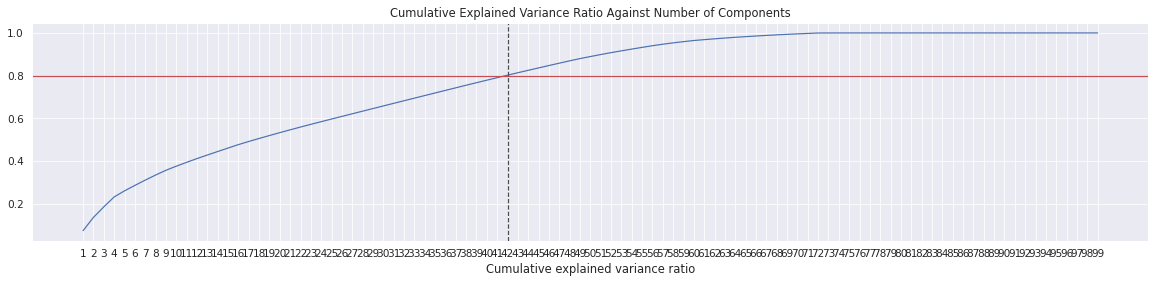

In [ ]:
# plot to find optimal number of components to use 
plt.figure().set_figwidth(20)
plt.plot(np.arange(1, len(cum_evr) + 1), cum_evr)
plt.xticks(range(1, len(cum_evr) + 1))
plt.axhline(y=0.8, color='r')
plt.axvline(x=42, color='0.3', linestyle='--')  #mark the cross point
plt.title('Cumulative Explained Variance Ratio Against Number of Components')
plt.xlabel('Number of components')
plt.xlabel('Cumulative explained variance ratio')
plt.show()

**Final PCA**

We maintained only principal components we selected.

In [ ]:
# Refit and transform on training with parameter n (as deduced from the last step) 
pca = PCA(n_components=42)
x_train_pca = pca.fit_transform(x_train_sc)

# Transform on Testing Set and store it as `x_test_pca`
x_test_pca = pca.transform(x_test_sc)

**Modeling and Training**

Conduct Logistic Regression on re-scaled training and test datasets after PCA.

In [ ]:
# Initialize `log_reg_pca` model with default parameters and fit it on the PCA transformed training set
log_reg_pca = LogisticRegression()
log_reg_pca.fit(x_train_pca, y_train)

# Use the model to predict on the PCA transformed test set and save these predictions as `y_pred`
y_pred = log_reg_pca.predict(x_test_pca)

# Find the accuracy and store the value in `test_accuracy`
test_accuracy = accuracy_score(y_test, y_pred)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
test_accuracy

0.7458496684574802

The accuracy of this model is passable, but not very satisfying, so we turned to other methods for a possibly better performance. Also, Logistic Regression is somehow abstract and not very intuitive to understand, while another method does better in this domain.

###Decision Tree

Decision Tree is another popular algorithm for classification. It learns by representing data and decision process as a tree, where each split point (non-leaf node of the tree) denotes a feature and each leaf node denotes a class label. One of its characteristics is scale-invariant, meaning that it does not need normalization and scaling beforehand. Moreover, the Decition Tree model is intuitive, easy to visualize and relatively easy to understand.

SciKit Learn has a well developed package for Decision Tree model, which is easy to apply.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt = dt.fit(x_train, y_train)

y_pred = dt.predict(x_test)

Due to the huge body of the current tree model, not only plotting this decision tree is time-comsuming, but the plot itself tends to have extremely low readability. Therefore, we will leave this part for a slimmer tree model.

In [ ]:
# accuracy
train_acc = dt.score(x_train,y_train)
test_acc = dt.score(x_test,y_test)

In [ ]:
train_acc

0.933337366892546

In [ ]:
test_acc

0.82808189342239

Taking a look at the train_acc and test_acc, there is a reasonable concern about **overfitting** since the accuracy of prediction on the training dataset is obviously higher than the accuracy of prediction on the testing dataset.

It is not surprising for a Decision Tree model. To address this, we are going to try PCA, limiting depth and ensembling (Random Forest) to help improve the performance of the model.

####Limit Depth

**Find an optimal depth**

To find a optimized value for the parameter max_depth, loop through reasonable values and calculate the accuracies for each model.

In [ ]:
lis_depth = []
lis_train_acc = []
lis_test_acc = []

for i in range(1, 31):
  # develop and train model
  op_dt = DecisionTreeClassifier(criterion="entropy", max_depth=i)
  op_dt = op_dt.fit(x_train, y_train)
  # accuracy
  train_acc = op_dt.score(x_train,y_train)
  test_acc = op_dt.score(x_test,y_test)
  # save values to corresponding lists
  lis_depth.append(i)
  lis_train_acc.append(train_acc)
  lis_test_acc.append(test_acc)

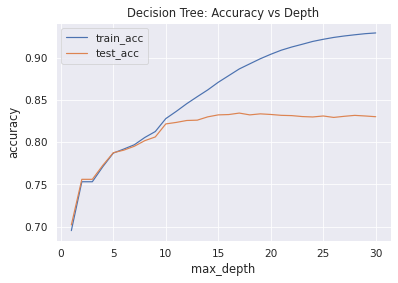

In [ ]:
# visualize
plt.plot(lis_depth, lis_train_acc, label='train_acc')
plt.plot(lis_depth, lis_test_acc, label='test_acc')
plt.title('Decision Tree: Accuracy vs Depth')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

With the value of depth increasing, the model obviously becomes more and more overfitting. 

After max_depth reaching 10, the difference between train_acc and test_acc increases significantly, which indicates that the model becomes increasingly overfitting, while the model rising depth only provides limited improvement to the accuracy of prediction on testing dataset. Based on this, we decided to set max_depth as 10.

**Establish Model with Optimized Depth**

In [ ]:
# develop and train model
op_dt = DecisionTreeClassifier(criterion="entropy", max_depth=10)
op_dt = op_dt.fit(x_train, y_train)
# accuracy
train_acc = op_dt.score(x_train,y_train)
test_acc = op_dt.score(x_test,y_test)

In [ ]:
train_acc

0.8278436592449178

In [ ]:
test_acc

0.821451043027927

By reducing the depth of the decision tree, we slightly compromised our testing accuracy, but nicely solved the problem of overfitting.

In [ ]:
pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Visualization**

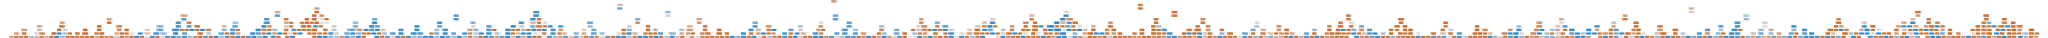

In [ ]:
import graphviz 
from sklearn.tree import export_graphviz

feature_names=list(features.columns)
class_names = ['Plant-based', 'Not Plant-based']

dot_data = export_graphviz(op_dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

###Random Forest

####Limit Depth

**Find an optimal depth**

We also want to determine an optimal value for max_depth parameter while establishing the random forest model. Again, we are using a loop to record accuracies for models with different depths.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

lis_depth = []
lis_train_acc = []
lis_test_acc = []

for i in range(1, 31):
  # develop and train model
  rf = RandomForestClassifier(n_estimators = 20, max_depth=i)
  rf = rf.fit(x_train, y_train)
  # accuracy
  train_acc = rf.score(x_train,y_train)
  test_acc = rf.score(x_test,y_test)
  # save values to corresponding lists
  lis_depth.append(i)
  lis_train_acc.append(train_acc)
  lis_test_acc.append(test_acc)

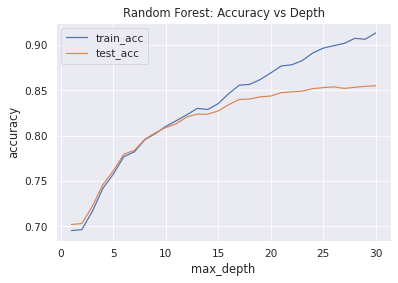

In [ ]:
# visualize
plt.plot(lis_depth, lis_train_acc, label='train_acc')
plt.plot(lis_depth, lis_test_acc, label='test_acc')
plt.title('Random Forest: Accuracy vs Depth')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

With the value of depth increasing, the model still becomes more and more overfitting. However, we see significant improvement in the accuracy of predicion on test dataset. 

According to the plot, we decided to set max_depth as 14, where the difference between train_acc and test_acc is small and prediction on test dataset has a relatively good performance.

**Establish Model with Optimized Depth**

In [ ]:
# develop and train model
rf = RandomForestClassifier(n_estimators = 20, max_depth=14) 
rf = rf.fit(x_train, y_train)
# accuracy
train_acc = rf.score(x_train,y_train)
test_acc = rf.score(x_test,y_test)

In [ ]:
train_acc

0.8334341723136496

In [ ]:
test_acc

0.826436280915735


##Sugary Foods: Binary Classification

We used the decision tree first because it has speed and can be explained. Then we tried random forest and neural networks to improve accuracy.

When choosing features, we deleted the columns of 'sugars_100g' and 'carbohydrates_100g' columns. Carbohydrates are sugars are directly related to sugar. Sugar is a type of carbohydrate found naturally in many of the foods we eat.

###Data Preprocessing

####Cleaning

In [ ]:
food_contents_df = food_df.drop(columns=['code','url','creator','created_t','created_datetime','last_modified_t','last_modified_datetime'
                                                      ,'generic_name','quantity','packaging','packaging_tags','brands','brands_tags','categories'
                                                      ,'categories_tags','origins','origins_tags','manufacturing_places','manufacturing_places_tags'
                                                      ,'labels','labels_tags','labels_en','emb_codes','emb_codes_tags','first_packaging_code_geo'
                                                      ,'cities','cities_tags','purchase_places','stores','countries','countries_tags','countries_en'
                                                      ,'ingredients_text','allergens','allergens_en','traces','traces_tags','traces_en'
                                                      ,'serving_size','additives_n','additives','additives_tags','additives_en'
                                                      ,'ingredients_from_palm_oil_n','ingredients_from_palm_oil_tags'
                                                      ,'ingredients_that_may_be_from_palm_oil_n'
                                                      ,'ingredients_that_may_be_from_palm_oil_tags','nutrition_grade_fr','pnns_groups_1','pnns_groups_2'
                                                      ,'states','states_tags','states_en','main_category','main_category_en','image_url','image_small_url'
                                                      ,'ph_100g','carbon-footprint_100g','nutrition-score-fr_100g'])

In [ ]:
#drop those rows without category
sugar_food_df = food_contents_df.dropna(subset=['categories_en'])
sugar_food_df['categories_en'].unique()

array(['fr:Filet-de-boeuf',
       'Plant-based foods and beverages,Plant-based foods,Fresh foods,Fruits and vegetables based foods,Fresh plant-based foods,Vegetables based foods,Fresh vegetables,Leaf vegetables',
       'Sugary snacks,Biscuits and cakes,Pastries', ...,
       'Plant-based foods and beverages,Plant-based foods,Fruits and vegetables based foods,Fruits based foods,Fruits,Citrus,Limes,ru:Лайм',
       'Beverages,Alcoholic beverages,Wines,French wines,White wines,fr:Bugey',
       'pl:Szprot'], dtype=object)

In [ ]:
sugar_food_df = sugar_food_df.dropna(subset=['categories_en'])
# fill nan with 0 in each row
sugar_food_df=sugar_food_df.fillna(0)

#### Feature Engineering

We create sugar column. This below checks if a product is sugarly or not. This information can be found in the category column

In [ ]:
# Check if it is sugar based
def ifSugarBased(x):
  if "Sugary" in x:
    return 1.0
  else:
    return 0.0

sugar_food_df['sugar'] = sugar_food_df['categories_en'].apply(ifSugarBased)

####Identify Imbalance

As shown below, we can see that the data is imbalanced for the label. We have much more data that fall into non sugary category.

In [ ]:
# we can see that we have much more non-sugar product
sugar_food_df['sugar'].value_counts()

0.0    89558
1.0    13743
Name: sugar, dtype: int64

Text(0, 0.5, 'The number of count')

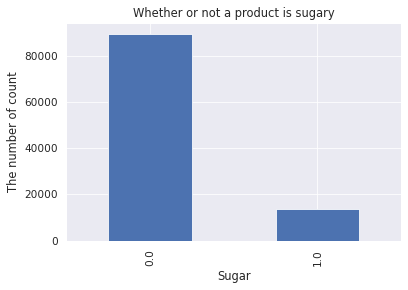

In [ ]:
from matplotlib import pyplot as plt
sugar_food_df['sugar'].value_counts().plot(kind="bar", title="test")

plt.title("Whether or not a product is sugary")
plt.xlabel("Sugar")
plt.ylabel("The number of count")

### Decision Tree

Given the dataset, we want to build a decision tree classifier in order to classify whether a product is sugary or not based on certain features. 

The decision tree model we use greedily determines the attribute on which to split by maximizing information gain.Then, we will estimate how accurately the classifier or model can predict the type of sugarly product. We got a classification rate of 92% before the oversampling, considered as good accuracy. 

#### Before oversampling

We first just implement the model as normal and do not consider data imbalance for our label.

In [ ]:
# delete them because they are object
sugar_food_df.dtypes[sugar_food_df.dtypes != 'int64'][sugar_food_df.dtypes != 'float64']

product_name     object
categories_en    object
dtype: object

In [ ]:
#store the columns to be used as features in a DataFrame called "features" 
features = sugar_food_df.drop(columns=['sugar','product_name', 'categories_en', 'sugars_100g', 'carbohydrates_100g', 'energy_100g', 'energy-from-fat_100g','nutrition-score-uk_100g'])
#store the target variable as "labels"
labels = sugar_food_df['sugar']

In [ ]:
from sklearn.model_selection import train_test_split
#conduct 70/30 train-test split
seed = 40
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.3, random_state = seed)

In [ ]:
# Load libraries
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(x_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(x_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9179439192023491


####Balancing Training Data
We use oversampling to solve the problem of data imbalance. We have a large number of trainning examples that fall into non-sugar class. So we add some of underrepresented examples to solve the problem and run the decision tree.

In [ ]:
# use down-sampling to solve data imbalance 
from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(random_state=42)
x_res, y_res = rus.fit_resample(x_train, y_train)

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(x_res,y_res)

#Predict the response for test dataset
y_pred = clf.predict(x_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.9173631054177019


### Random Forest

We use a bagging ensemble method, random forest to increase the accuracy of the model. But at the same time, it will take longer time.

We also use `feature_importances_`to reflect the order of the columns in my features dataframe so we can see which feature is more important. It is interesting to see that saturated fat (saturated-fat) has one of the highest predicting power (18%) in whether or not a type of product is sugar.

When we instantiate model with 100 decision trees, this model has an accuracy score of 94% on the test data before the oversampling, which  seems impressive and better than the decision tree model.

#### Before oversampling

As before, we first just implement the model as normal and do not consider data imbalance for our label.

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 10 decision trees
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train);

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(x_test)

In [ ]:
# View accuracy score
print("Accuracy:",metrics.accuracy_score(y_test, predictions))

Accuracy: 0.9363040882836953


####Balancing Training Data
We use oversampling to solve the problem of data imbalance. We have a large number of trainning examples that fall into non-sugar class. So we add some of underrepresented examples to solve the problem and run the random forest.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(random_state=42)
x_res, y_res = rus.fit_resample(x_train, y_train)

rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
# Train the model on training data
rf.fit(x_res, y_res);

predictions = rf.predict(x_test)

print("Accuracy:",metrics.accuracy_score(y_test, predictions))

Accuracy: 0.9352715304443225


####Feature Importances

We do feature importance and try to see which feature has more power in determining whether or not a product is sugary.

In [ ]:
# check which feature is more important
importances = rf.feature_importances_

i = 0
while i < len(x_train.columns):
  print(f"The importance of feature '{x_train.columns[i]}' is {round(importances[i]*100, 2)}%.")
  i = i + 1

The importance of feature 'no_nutriments' is 0.0%.
The importance of feature 'ingredients_from_palm_oil' is 0.0%.
The importance of feature 'ingredients_that_may_be_from_palm_oil' is 0.0%.
The importance of feature 'nutrition_grade_uk' is 0.0%.
The importance of feature 'fat_100g' is 20.84%.
The importance of feature 'saturated-fat_100g' is 17.06%.
The importance of feature '-butyric-acid_100g' is 0.0%.
The importance of feature '-caproic-acid_100g' is 0.0%.
The importance of feature '-caprylic-acid_100g' is 0.0%.
The importance of feature '-capric-acid_100g' is 0.0%.
The importance of feature '-lauric-acid_100g' is 0.0%.
The importance of feature '-myristic-acid_100g' is 0.0%.
The importance of feature '-palmitic-acid_100g' is 0.0%.
The importance of feature '-stearic-acid_100g' is 0.0%.
The importance of feature '-arachidic-acid_100g' is 0.0%.
The importance of feature '-behenic-acid_100g' is 0.0%.
The importance of feature '-lignoceric-acid_100g' is 0.0%.
The importance of feature '

### FeedForward Neural Network

We use the first and simplest type of artificial neural network devised to increase the accuracy of the model. But at the same time, it will take longer time.

This model has an accuracy score of 91% on the test data before the oversampling, which is good. However, the result is not as good as the results we derived from the random forest model. Therefore, we got the best result by using random forest model in the last session.

#### Normalize Data

We normalize data before implementing the model. The model is affected by the value range of features. We did not do this for decision trees and random forests because they are scale-invariant.

In [ ]:
from keras import models, layers, optimizers, regularizers
from sklearn import model_selection, preprocessing
import tensorflow as tf

In [ ]:
x_train_normalize = preprocessing.normalize(x_train)
x_test_normalize = preprocessing.normalize(x_test)

#### Before oversampling

As before, we first just implement the model as normal and do not consider data imbalance for our label. Since the result is not as good as the result of random forest, we will not go furhter and do oversampling for this model.

In [ ]:
hidden_units = 100     # how many neurons in the hidden layer
activation = 'relu'   # activation function for hidden layer
l2 = 0.01             # regularization - how much we penalize large parameter values
learning_rate = 0.01  # how big our steps are in gradient descent
epochs = 5          # how many epochs to train for
batch_size = 64     # how many samples to use for each gradient descent update

In [ ]:
# create a sequential model
model = models.Sequential()

# add the hidden layer
model.add(layers.Dense(input_dim=x_train.shape[1],
                       units=hidden_units, 
                       activation=activation))

# add the output layer
model.add(layers.Dense(input_dim=hidden_units,
                       units=1,
                       activation='sigmoid'))

# define our loss function and optimizer
model.compile(loss='binary_crossentropy',
              # Adam is a kind of gradient descent
              optimizer=optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# train the parameters
history = model.fit(x_train_normalize, y_train, epochs=5, batch_size=batch_size)

# evaluate accuracy
train_acc = model.evaluate(x_train_normalize, y_train, batch_size=32)[1]
test_acc = model.evaluate(x_test_normalize, y_test, batch_size=32)[1]
# print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

Epoch 1/5
1130/1130 [==============================] - 4s 2ms/step - loss: 0.2770 - accuracy: 0.8957
Epoch 2/5
1130/1130 [==============================] - 3s 2ms/step - loss: 0.2541 - accuracy: 0.9044
Epoch 3/5
1130/1130 [==============================] - 3s 2ms/step - loss: 0.2468 - accuracy: 0.9067
Epoch 4/5
1130/1130 [==============================] - 3s 2ms/step - loss: 0.2416 - accuracy: 0.9091
Epoch 5/5
969/969 [==============================] - 4s 4ms/step - loss: 0.2314 - accuracy: 0.9133
Testing accuracy: 0.9133296608924866


##Energy of Foods: Multi-Classification

Energy is one of the most essential factor in assessing the nutritional value of foods, and thus receives fair amount of attention. Nowadays, people are becoming increasingly concerned about the energy content of food products, not only because they want to maintain their physical performance, but also because they want to maintain healthy weights and body shapes. Controlling the quantity of energy consumed is the most important component of losing weight, which is a long-lasting hot topic on social media platforms. Therefore, when consumers are deciding whether or not to purchase a food product, they undoubtedly take its energy content into consideration. Furthermore, as weight loss applications grow more popular, many people utilize them to help calculate the amount of energy they consume on a daily basis, which makes energy prediction based on food contents more demanded.

We believe that it is possible and conceivable to determine the energy level a food product according to its components. Thus in this section, we tried to classify products into three categories, namely high-energy, medium-energy, and low-energy, according to their quantitative contents.

###Data Preprocessing

#### Cleaning

We dropped those columns whose values are not numeric and those irrelavant to this part of study.

In [ ]:
food_energy_df = plant_food_df.drop(columns=['product_name','categories_en', 'plant_based', 'energy-from-fat_100g','nutrition-score-uk_100g'])

In [ ]:
food_energy_df.columns

Index(['no_nutriments', 'ingredients_from_palm_oil',
       'ingredients_that_may_be_from_palm_oil', 'nutrition_grade_uk',
       'energy_100g', 'fat_100g', 'saturated-fat_100g', '-butyric-acid_100g',
       '-caproic-acid_100g', '-caprylic-acid_100g', '-capric-acid_100g',
       '-lauric-acid_100g', '-myristic-acid_100g', '-palmitic-acid_100g',
       '-stearic-acid_100g', '-arachidic-acid_100g', '-behenic-acid_100g',
       '-lignoceric-acid_100g', '-cerotic-acid_100g', '-montanic-acid_100g',
       '-melissic-acid_100g', 'monounsaturated-fat_100g',
       'polyunsaturated-fat_100g', 'omega-3-fat_100g',
       '-alpha-linolenic-acid_100g', '-eicosapentaenoic-acid_100g',
       '-docosahexaenoic-acid_100g', 'omega-6-fat_100g', '-linoleic-acid_100g',
       '-arachidonic-acid_100g', '-gamma-linolenic-acid_100g',
       '-dihomo-gamma-linolenic-acid_100g', 'omega-9-fat_100g',
       '-oleic-acid_100g', '-elaidic-acid_100g', '-gondoic-acid_100g',
       '-mead-acid_100g', '-erucic-acid_1

#### Feature Engineering


We split energy values uniformly into 3 level groups so as to make sure that each group has same or similar number of instances and avoid imbalance. Based on this idea, we calculate quantiles as the thresholds used to assign levels.

In [ ]:
lo = food_energy_df['energy_100g'].quantile(q=1/3)
hi = food_energy_df['energy_100g'].quantile(q=2/3)

As calculated above, 2/3 products are with energy lower than the *hi* threshold, and 1/3 products are with energy lower than the *lo* threshold. According to this statistical results, we split energy into three levels: 

> high (>hi),

> medium (in the range between lo and hi, inclusively), and 

> low (<lo). 

We then created a new column called 'energy_level' to indicate whether a product is high-energy (type: 1), medium-energy (type: 2) or low-energy (type: 3).

In [ ]:
def energyLevel(x):
  if x > hi:
    return 1
  elif x < lo:
    return 3
  else:
    return 2

In [ ]:
food_energy_df['energy_level'] = food_energy_df['energy_100g'].apply(energyLevel)

In [ ]:
food_energy_df = food_energy_df.drop(columns=['energy_100g'])

####Set up for Modeling

In [ ]:
#store the columns to be used as features in a DataFrame called "features" 
features = food_energy_df.drop(columns=['energy_level'])
#store the binary classification target variable as "labels"
labels = food_energy_df['energy_level']

In [ ]:
#conduct 80/20 train-test split
seed = 42
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = seed)

###Decision Tree

In [ ]:
# modeling and training
dt = DecisionTreeClassifier()
dt = dt.fit(x_train, y_train)
# accuracy
train_acc = dt.score(x_train,y_train)
test_acc = dt.score(x_test,y_test)

In [ ]:
print(f'Training Accuracy: {train_acc}.')
print(f'Test Accuracy: {test_acc}.')

Training Accuracy: 0.9966602129719264.
Test Accuracy: 0.9580368810802962.


A slight sign of overfitting can be seen from the difference between the training accuracy and the test accuracy, so we tried to address this in the below section.

####Limit Depth

To address overfitting, we need to reduce the complexity of our model. One of the most efficient way of doing this on a Decition Tree model is to limit the maximum depth of the tree.

In [ ]:
lis_depth = []
lis_train_acc = []
lis_test_acc = []

for i in range(1, 31):
  # develop and train model
  op_dt = DecisionTreeClassifier(criterion="entropy", max_depth=i)
  op_dt = op_dt.fit(x_train, y_train)
  # accuracy
  train_acc = op_dt.score(x_train,y_train)
  test_acc = op_dt.score(x_test,y_test)
  # save values to corresponding lists
  lis_depth.append(i)
  lis_train_acc.append(train_acc)
  lis_test_acc.append(test_acc)

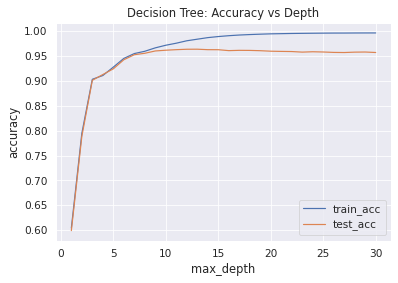

In [ ]:
# visualize
plt.plot(lis_depth, lis_train_acc, label='train_acc')
plt.plot(lis_depth, lis_test_acc, label='test_acc')
plt.title('Decision Tree: Accuracy vs Depth')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

We chose 10 as the largest max_depth with tolerable difference between train_acc and test_acc, which indicates the degree of overfitting.

In [ ]:
# develop and train model
op_dt = DecisionTreeClassifier(criterion="entropy", max_depth=10)
op_dt = op_dt.fit(x_train, y_train)
# accuracy
train_acc = op_dt.score(x_train,y_train)
test_acc = op_dt.score(x_test,y_test)

In [ ]:
print(f'Training Accuracy: {train_acc}.')
print(f'Test Accuracy: {test_acc}.')

Training Accuracy: 0.9717933204259439.
Test Accuracy: 0.9620541116112482.


We successfully decreased the difference between training accuracy and test accuracy from 0.04 to 0.01.

###Random Forest

We wanted to see if emsembling makes our model better for this particular classification. Random Forest is a way of bagging. It creates many trees on subsets of the data and combines the output by majority votes. In reduces overfitting in decision trees and improves the accuracy. Also, it is robust to outliers, though we did not noticed this problem in this classification.

In [ ]:
# develop and train model
rf = RandomForestClassifier(n_estimators = 20) 
rf = rf.fit(x_train, y_train)
# accuracy
train_acc = rf.score(x_train,y_train)
test_acc = rf.score(x_test,y_test)

In [ ]:
print(f'Training Accuracy: {train_acc}.')
print(f'Test Accuracy: {test_acc}.')

Training Accuracy: 0.9957768635043562.
Test Accuracy: 0.9658777406708291.


Compared with the Decision Tree model, this Random Forest model suffers less from overfitting when using default parameters, without additionally limiting maximum depth.

####Limit Depth

In [ ]:
lis_depth = []
lis_train_acc = []
lis_test_acc = []

for i in range(1, 31):
  # develop and train model
  op_rf = RandomForestClassifier(n_estimators = 20, max_depth=i)
  op_rf = op_rf.fit(x_train, y_train)
  # accuracy
  train_acc = op_rf.score(x_train,y_train)
  test_acc = op_rf.score(x_test,y_test)
  # save values to corresponding lists
  lis_depth.append(i)
  lis_train_acc.append(train_acc)
  lis_test_acc.append(test_acc)

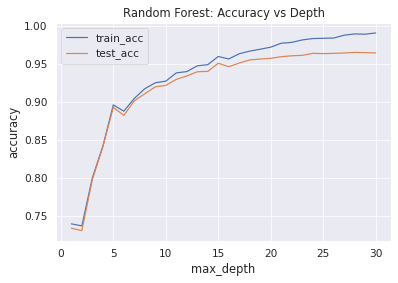

In [ ]:
# visualize
plt.plot(lis_depth, lis_train_acc, label='train_acc')
plt.plot(lis_depth, lis_test_acc, label='test_acc')
plt.title('Random Forest: Accuracy vs Depth')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
# develop and train model
op_rf = RandomForestClassifier(n_estimators = 20, max_depth=13) 
op_rf = op_rf.fit(x_train, y_train)
# accuracy
train_acc = op_rf.score(x_train,y_train)
test_acc = op_rf.score(x_test,y_test)

In [ ]:
print(f'Training Accuracy: {train_acc}.')
print(f'Test Accuracy: {test_acc}.')

Training Accuracy: 0.9446999031945789.
Test Accuracy: 0.9364019166545666.


By limiting the max_depth of the Random Forest model, we slightly compromised our testing accuracy, but reduced the degree of overfitting.

In this particular classification, Random Forest showed slight improvement on dealing with overfitting compare with Decision Tree, but showed no significant advantages considering overall performance.

##Nutrition Score Prediction: Regression

###Data Preprocessing

In [ ]:
#drop unused columns
score_food_df = food_contents_df.drop(columns=['product_name', 'categories_en'])
#drop those rows without category
score_food_df = score_food_df.dropna(subset=['nutrition-score-uk_100g'])
#fill nan
score_food_df = score_food_df.fillna(0)

In [ ]:
# to display full list (disable truncate view)
pd.set_option("display.max_rows", None)

In [ ]:
for column in score_food_df.columns:
  print(column)

no_nutriments
ingredients_from_palm_oil
ingredients_that_may_be_from_palm_oil
nutrition_grade_uk
energy_100g
energy-from-fat_100g
fat_100g
saturated-fat_100g
-butyric-acid_100g
-caproic-acid_100g
-caprylic-acid_100g
-capric-acid_100g
-lauric-acid_100g
-myristic-acid_100g
-palmitic-acid_100g
-stearic-acid_100g
-arachidic-acid_100g
-behenic-acid_100g
-lignoceric-acid_100g
-cerotic-acid_100g
-montanic-acid_100g
-melissic-acid_100g
monounsaturated-fat_100g
polyunsaturated-fat_100g
omega-3-fat_100g
-alpha-linolenic-acid_100g
-eicosapentaenoic-acid_100g
-docosahexaenoic-acid_100g
omega-6-fat_100g
-linoleic-acid_100g
-arachidonic-acid_100g
-gamma-linolenic-acid_100g
-dihomo-gamma-linolenic-acid_100g
omega-9-fat_100g
-oleic-acid_100g
-elaidic-acid_100g
-gondoic-acid_100g
-mead-acid_100g
-erucic-acid_100g
-nervonic-acid_100g
trans-fat_100g
cholesterol_100g
carbohydrates_100g
sugars_100g
-sucrose_100g
-glucose_100g
-fructose_100g
-lactose_100g
-maltose_100g
-maltodextrins_100g
starch_100g
polyol

In [ ]:
score_food_df.dtypes

no_nutriments                            float64
ingredients_from_palm_oil                float64
ingredients_that_may_be_from_palm_oil    float64
nutrition_grade_uk                       float64
energy_100g                              float64
energy-from-fat_100g                     float64
fat_100g                                 float64
saturated-fat_100g                       float64
-butyric-acid_100g                       float64
-caproic-acid_100g                       float64
-caprylic-acid_100g                      float64
-capric-acid_100g                        float64
-lauric-acid_100g                        float64
-myristic-acid_100g                      float64
-palmitic-acid_100g                      float64
-stearic-acid_100g                       float64
-arachidic-acid_100g                     float64
-behenic-acid_100g                       float64
-lignoceric-acid_100g                    float64
-cerotic-acid_100g                       float64
-montanic-acid_100g 

In [ ]:
#store the columns to be used as features in a DataFrame called "features" 
features = score_food_df.drop(columns=['nutrition-score-uk_100g'])
#store the binary classification target variable as "labels"
labels = score_food_df['nutrition-score-uk_100g']

In [ ]:
from sklearn.model_selection import train_test_split
#conduct 80/20 train-test split
seed = 42
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = seed)

###Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error

# Initialize model with default parameters and fit it on the training set
reg = LinearRegression()
reg.fit(x_train, y_train)
# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = reg.predict(x_test)
# Find the R-squared score and RMSE score
linear_score = r2_score(y_test, y_pred)
linear_score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#score(accuracy)
train_acc =reg.score(x_train,y_train)
test_acc =reg.score(x_test,y_test)

In [ ]:
print(f'R2 score: {linear_score}.')
print(f'RMSE score: {linear_score_rmse}.')
print(f'Training Accuracy: {train_acc}.')
print(f'Test Accuracy: {test_acc}.')

R2 score: 0.6025936059951933.
RMSE score: 5.764462017519124.
Training Accuracy: 0.6025081519813442.
Test Accuracy: 0.6025936059951933.


###Lasso Regularized Linear Regression

In [ ]:
from sklearn.linear_model import Lasso

# Initialize model with default parameters and fit it on the PCA transformed training set
lasso = Lasso(alpha = 0.1)
lasso.fit(x_train, y_train)

# Use the model to predict on the PCA transformed test set and save these predictions as `y_pred`
y_pred = lasso.predict(x_test)

# Find the R-squared score and store the value in `ridge_score`
lasso_score = r2_score(y_test, y_pred)
lasso_score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

#score(accuracy)
train_acc_ls =lasso.score(x_train,y_train)
test_acc_ls =lasso.score(x_test,y_test)

In [ ]:
print(f'R2 score: {lasso_score}.')
print(f'RMSE score: {lasso_score_rmse}.')
print(f'Training Accuracy: {train_acc_ls}.')
print(f'Test Accuracy: {test_acc_ls}.')

R2 score: 0.6163106066340134.
RMSE score: 5.66410445287924.
Training Accuracy: 0.6017242210390565.
Test Accuracy: 0.6163106066340134.


####Cross-Validation

Select optimal alpha value using cross-validation.

In [ ]:
from sklearn.linear_model import LassoCV

#Lasso Cross validation
lasso_cv = LassoCV(alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5], random_state=0).fit(x_train, y_train)
# Use the model to predict on the PCA transformed test set and save these predictions as `y_pred`
y_pred = lasso_cv.predict(x_test)

# Find the R-squared score and store the value in `ridge_score`
lasso_score = r2_score(y_test, y_pred)
lasso_score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

#score(accuracy)
train_acc_ls =lasso.score(x_train,y_train)
test_acc_ls =lasso.score(x_test,y_test)

In [ ]:
print(f'R2 score: {lasso_score}.')
print(f'RMSE score: {lasso_score_rmse}.')
print(f'Training Accuracy: {train_acc_ls}.')
print(f'Test Accuracy: {test_acc_ls}.')

R2 score: 0.6163863481899654.
RMSE score: 5.663545368805315.
Training Accuracy: 0.6017242210390565.
Test Accuracy: 0.6163106066340134.


###Ridge Regularized Linear Regression

In [ ]:
from sklearn.linear_model import Ridge
# Initialize model and fit it
reg_ridge = Ridge(alpha=100)
reg_ridge.fit(x_train, y_train)
# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = reg_ridge.predict(x_test)
# Find the R-squared score and store the value in `ridge_score`
ridge_score = r2_score(y_test, y_pred)
ridge_score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#score(accuracy)
train_acc_rdg =reg_ridge.score(x_train,y_train)
test_acc_rdg =reg_ridge.score(x_test,y_test)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.15211e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


In [ ]:
print(f'R2 score: {ridge_score}.')
print(f'RMSE score: {ridge_score_rmse}.')
print(f'Training Accuracy: {train_acc_rdg}.')
print(f'Test Accuracy: {test_acc_rdg}.')

R2 score: 0.6150254277386298.
RMSE score: 5.673582564845186.
Training Accuracy: 0.6023583932897261.
Test Accuracy: 0.6150254277386298.


###Elastic Net Regularized Linear Regression

In [ ]:
from sklearn.linear_model import ElasticNet
# Initialize model and fit it on the training set
en = ElasticNet(alpha=2.5, l1_ratio=0.1)
en.fit(x_train, y_train)
# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = en.predict(x_test)
# Find the R-squared score and store the value in `ridge_score`
en_score = r2_score(y_test, y_pred)
en_score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#score(accuracy)
train_acc_en =en.score(x_train,y_train)
test_acc_en =en.score(x_test,y_test)

In [ ]:
print(f'R2 score: {en_score}.')
print(f'RMSE score: {en_score_rmse}.')
print(f'Training Accuracy: {train_acc_en}.')
print(f'Test Accuracy: {test_acc_en}.')

R2 score: 0.6168699631793043.
RMSE score: 5.65997427688856.
Training Accuracy: 0.6007285444041129.
Test Accuracy: 0.6168699631793043.


#**Conclusions**

##Preprocessing

We have a huge and diverse training set but with a large number of missing values for most columns. When we do value imputation, we could try to fill the same value such as zero or mean value into each null, for a given feature. We also try to drop some outliers in the data when it comes to columns related to energy, fat and sugars because unsupervised learning methods such as K-means clustering are very sensitive to outliers.


##EDA


Through our visualizations, we could see how different features are related to each other and how different products are represented by these features. As topics extended from this part, we then analyzed interrelations between selected features using different visualizations and statistical methods.

The geography-based section of our EDA breifly discussed the number of products in different countries. We can see that most products in the dataset are from the US and France. The differences are quite significant, so we can focus on one major country, namely United States, in some of our sections.

We then examined product names for all categories and some particular categories for comparison. Based on previous parts of EDA, we selected plant-based foods and sugary foods as our special focus for not only this section but also later sections of supervised learning.

##Modeling

We divided our learning models into two major types, unsupervised learning and supervised learning, for neatness and organization.

###Unsupervised Learning

We've covered three methods of clustering in this project: k-means, hierarchical clustering, and gaussian mixture models. In the process, we observe that k-means is highly subject to influence of outliers despite we've already dropped outliers! We still have several data cases with extreme salt value in this case. While we are highly susceptible about these data, we are not provided with enough information to rule out these outliers. Nonetheless, we do observe their messy perfomance in k-means. 

In the second clustering method, we choose 1000 sample data to run for the sake of running time and ram. We did agglomerative hierchical clustering and choose cluster number according to the cluster line which has maximal depth that does not cross other cluster lines in the dendogram. Though derive a different cluster number than k-means, the performance is good.

In the third clustering method, which is gaussian mixture model. This model clearly provided a enlighted version of k-means, as it does better on outlier clusters which only had one data in k-means. With the six wordclouds generated, we can roughly interpret each cluster's significations, which is awesome.

###Supervised Learning

The first part of supervised learning is classifications. We conducted binary classifications as well as multi-classification.

We first implemented a binary classification to predict whether a food product is plant-based or not given its contents. We initially applied Logistic Regression model and achieved not too bad but also not satisfying performance, with accuracy less than 75%. We applied PCA but got very little improvement. Then we tried the Decision Tree and Random Forest models, which delivered better accuracies. For these two models, we mainly tried to solve the overfitting problem. We limited their depth and managed to reduce overfitting successfully. To find optimal parameters, we used a loop to keep records of performance for different depth values and plot accuracies against the parameter to identify a suitable value. Eventually, we achieved 83% accuracy with little or no overfitting.

For binary classification in terms of whether or not a product is sugary, we are given a nutrition dataset and want to build a decision tree classifier in order to classify whether a product has more sugar or not. After that, we also use random forest and NN to improve performance. Random forest gives the best result of 94% accuracy on test data. In random forest model, when looking at feature importance, we can see that saturated fat has one of the highest predicting power. It is interesting because this may imply that sugar products are not that healthy. Saturated fat is a type of dietary fat. It is one of the unhealthy fats, along with trans fat. Foods like butter, palm and coconut oils, cheese, and red meat have high amounts of saturated fat. After the models, we use oversampling to solve the problem of data imbalance in sugar classification problem. We achieve balance across classes within our training set. We have a large number of trainning examples that fall into non-sugar class and not the other. The classifer can default to predicting the more frequent of the outcomes. After the oversampling, the random forest model still has the best performance of 94% accuracy.

After binary classifications, we predicted the energy of a food product according to its contents using multi-classification. In this part of learning, we chose Decision Tree and Random Forest as models, and tried to improve their performances by limiting their maximum depths. In the end, we managed to achieve 96% test accuracy. We speculated that this high accuracy might be due to the fact that energy of foods is largely and directly determined by some contents such as fat and carbs, so it can be simple to predict.

In the last section, we predicted the Nutrition Score of a food product. We picked Linear Regression models as it suits preditions on this kind of targets with continuous values. We tried LASSO, Ridge, and Elastic Net Regularizations not only to improve the performance of our model but also to better understand these models by comparisons.

##**Potential Next Steps**

The dataset contains multiple languages, among which English and French accounts for the majority. Due to the limit of GPU and for a acceptable speed of computation, we mainly focused on English entries while doing test-relavant analysis. For a potential future step, translations can be done on category and product_name columns for better wordclouds and further test analysis.

We could try to find extra data about the reviews of the products mentioned in the open food fact dataset and see if we could strengthen our regression model by combining the results of sentiment analysis. But this requires specific reviews on the products about nutrition more than just information about appearance or taste.

For both unsupervised and supervised learning models, there might be more ways of improvements. Also, there are more models that can be used on this dataset and they might have great performances.